In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import sys

import numpy as np

NUMBER_OF_GAUSSIANS = 2

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (2,) #  (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 1

        optimizer = Adam(0.0002, 0.9)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):
        
        
        model = Sequential(name='Generator')
        with tf.name_scope('Generator'):
            model.add(Dense(10, input_dim=self.latent_dim,name='g_fc_1'))
            model.add(LeakyReLU(alpha=0.2))
#             model.add(BatchNormalization(momentum=0.8, name='g_bn_1'))
            
            model.add(Dense(25, name='g_fc_2'))
            model.add(LeakyReLU(alpha=0.2))
#             model.add(BatchNormalization(momentum=0.8,name='g_bn_2'))
            
#             model.add(Dense(200, name='g_fc_3'))
#             model.add(LeakyReLU(alpha=0.2))
#             model.add(BatchNormalization(momentum=0.8, name='g_bn_3'))
            
            model.add(Dense(2,name='Generate'))
#             model.add(Reshape(self.img_shape))

            model.summary()

            noise = Input(shape=(self.latent_dim,))
            img = model(noise)

            return Model(noise, img)

    def build_discriminator(self):

        model = Sequential(name='Discriminator')

        with tf.name_scope('Discriminator'):
            #model.add(Flatten(input_shape=self.img_shape))
            model.add(Dense(25, input_shape=self.img_shape, name='d_fc_0'))
            model.add(LeakyReLU(alpha=0.2))
#             model.add(BatchNormalization(momentum=0.8, name='g_bn_0'))
            
            model.add(Dense(10, name='d_fc_1'))
            model.add(LeakyReLU(alpha=0.2))
#             model.add(BatchNormalization(momentum=0.8, name='g_bn_1'))
            
#             model.add(Dense(50, name='d_fc_2'))
#             model.add(LeakyReLU(alpha=0.2))
#             model.add(BatchNormalization(momentum=0.8, name='g_bn_2'))
            
            model.add(Dense(1, activation='sigmoid', name='Discriminate'))
            model.summary()

            img = Input(shape=self.img_shape)
            validity = model(img)

            return Model(img, validity)

    def train(self, epochs, batch_size=64, sample_interval=50):

        # Load the dataset
#         (X_train, _), (_, _) = mnist.load_data()

        def sample_toy_distr():
            x = np.random.normal(0, 0.1)
            y = np.random.normal(0, 0.1)
#             centers = [(i*5,j*10) for i in range(NUMBER_OF_GAUSSIANS) for j in range(NUMBER_OF_GAUSSIANS)] 
            centers = [(0,-1), (1,0), (-0.5,0.5)]

            mu_x, mu_y = random.sample(centers,1)[0]
            return [x + mu_x, y + mu_y]

        def sample_data(batch_size):
            return np.array([sample_toy_distr() for _ in range(batch_size)])


        # Rescale -1 to 1
#         X_train = X_train / 127.5 - 1.
#         X_train = np.expand_dims(X_train, axis=3)
        X_train = sample_data(batch_size*50000)
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        tensorboard = keras.callbacks.TensorBoard(log_dir='model_out/keras-output', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
        tensorboard.set_model(self.combined)
        # Transform train_on_batch return value
        # to dict expected by on_batch_end callback
        def write_log(callback, name, value, batch_no):
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value
            summary_value.tag = name
            callback.writer.add_summary(summary, batch_no)
            callback.writer.flush()
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
            log = {'g_loss': g_loss, 'd_loss': d_loss}
            
            write_log(tensorboard, 'g_loss', g_loss, epoch)
            write_log(tensorboard, 'd_loss', d_loss[0], epoch)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
            

    def sample_images(self, epoch):
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
#         print(gen_imgs)
        return gen_imgs

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


Using TensorFlow backend.


In [2]:
gan = GAN()
gan.train(epochs=15000, batch_size=32, sample_interval=200)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_fc_0 (Dense)               (None, 25)                75        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 25)                0         
_________________________________________________________________
d_fc_1 (Dense)               (None, 10)                260       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
Discriminate (Dense)         (None, 1)                 11        
Total params: 346
Trainable params: 346
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
g_fc_1 (Dens

/home/nil/Apps/Anaconda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.711372, acc.: 64.06%] [G loss: 0.723703]
1 [D loss: 0.716823, acc.: 57.81%] [G loss: 0.706429]
2 [D loss: 0.723955, acc.: 53.12%] [G loss: 0.717244]
3 [D loss: 0.708496, acc.: 62.50%] [G loss: 0.715544]
4 [D loss: 0.711214, acc.: 50.00%] [G loss: 0.710959]
5 [D loss: 0.707889, acc.: 50.00%] [G loss: 0.712840]
6 [D loss: 0.707693, acc.: 48.44%] [G loss: 0.706176]
7 [D loss: 0.713726, acc.: 39.06%] [G loss: 0.707752]
8 [D loss: 0.711341, acc.: 43.75%] [G loss: 0.708284]
9 [D loss: 0.716462, acc.: 37.50%] [G loss: 0.709526]
10 [D loss: 0.718070, acc.: 43.75%] [G loss: 0.708945]
11 [D loss: 0.712285, acc.: 35.94%] [G loss: 0.708082]
12 [D loss: 0.712168, acc.: 45.31%] [G loss: 0.706508]
13 [D loss: 0.703157, acc.: 45.31%] [G loss: 0.706184]
14 [D loss: 0.705173, acc.: 34.38%] [G loss: 0.711937]
15 [D loss: 0.706935, acc.: 43.75%] [G loss: 0.705263]
16 [D loss: 0.704737, acc.: 42.19%] [G loss: 0.705534]
17 [D loss: 0.703612, acc.: 45.31%] [G loss: 0.698301]
18 [D loss: 0.716316

154 [D loss: 0.698595, acc.: 39.06%] [G loss: 0.662613]
155 [D loss: 0.681781, acc.: 51.56%] [G loss: 0.668810]
156 [D loss: 0.685900, acc.: 45.31%] [G loss: 0.675329]
157 [D loss: 0.687995, acc.: 42.19%] [G loss: 0.671576]
158 [D loss: 0.691693, acc.: 43.75%] [G loss: 0.682535]
159 [D loss: 0.691638, acc.: 43.75%] [G loss: 0.675403]
160 [D loss: 0.677969, acc.: 48.44%] [G loss: 0.666134]
161 [D loss: 0.681109, acc.: 54.69%] [G loss: 0.669146]
162 [D loss: 0.690302, acc.: 48.44%] [G loss: 0.670382]
163 [D loss: 0.685718, acc.: 51.56%] [G loss: 0.672947]
164 [D loss: 0.682618, acc.: 42.19%] [G loss: 0.669477]
165 [D loss: 0.686834, acc.: 45.31%] [G loss: 0.675395]
166 [D loss: 0.691299, acc.: 43.75%] [G loss: 0.674045]
167 [D loss: 0.698656, acc.: 43.75%] [G loss: 0.678953]
168 [D loss: 0.689508, acc.: 56.25%] [G loss: 0.671109]
169 [D loss: 0.679905, acc.: 50.00%] [G loss: 0.666866]
170 [D loss: 0.691580, acc.: 54.69%] [G loss: 0.667713]
171 [D loss: 0.703465, acc.: 37.50%] [G loss: 0.

315 [D loss: 0.693921, acc.: 65.62%] [G loss: 0.685607]
316 [D loss: 0.689329, acc.: 64.06%] [G loss: 0.689503]
317 [D loss: 0.692429, acc.: 64.06%] [G loss: 0.681248]
318 [D loss: 0.692963, acc.: 64.06%] [G loss: 0.687084]
319 [D loss: 0.692521, acc.: 62.50%] [G loss: 0.694398]
320 [D loss: 0.697997, acc.: 62.50%] [G loss: 0.681120]
321 [D loss: 0.696872, acc.: 59.38%] [G loss: 0.688401]
322 [D loss: 0.686868, acc.: 64.06%] [G loss: 0.683452]
323 [D loss: 0.686627, acc.: 62.50%] [G loss: 0.689734]
324 [D loss: 0.692223, acc.: 62.50%] [G loss: 0.702176]
325 [D loss: 0.692054, acc.: 62.50%] [G loss: 0.698381]
326 [D loss: 0.694613, acc.: 57.81%] [G loss: 0.695343]
327 [D loss: 0.689492, acc.: 62.50%] [G loss: 0.699615]
328 [D loss: 0.687582, acc.: 62.50%] [G loss: 0.694511]
329 [D loss: 0.681751, acc.: 73.44%] [G loss: 0.691394]
330 [D loss: 0.690761, acc.: 50.00%] [G loss: 0.700254]
331 [D loss: 0.682914, acc.: 64.06%] [G loss: 0.696910]
332 [D loss: 0.696341, acc.: 50.00%] [G loss: 0.

475 [D loss: 0.688075, acc.: 48.44%] [G loss: 0.715122]
476 [D loss: 0.688415, acc.: 56.25%] [G loss: 0.723081]
477 [D loss: 0.703220, acc.: 42.19%] [G loss: 0.710736]
478 [D loss: 0.695654, acc.: 46.88%] [G loss: 0.715088]
479 [D loss: 0.692861, acc.: 53.12%] [G loss: 0.710787]
480 [D loss: 0.700524, acc.: 46.88%] [G loss: 0.723641]
481 [D loss: 0.684893, acc.: 62.50%] [G loss: 0.722693]
482 [D loss: 0.694869, acc.: 51.56%] [G loss: 0.703065]
483 [D loss: 0.685574, acc.: 59.38%] [G loss: 0.718606]
484 [D loss: 0.698652, acc.: 53.12%] [G loss: 0.709882]
485 [D loss: 0.700016, acc.: 54.69%] [G loss: 0.712609]
486 [D loss: 0.688666, acc.: 57.81%] [G loss: 0.699789]
487 [D loss: 0.710021, acc.: 43.75%] [G loss: 0.722410]
488 [D loss: 0.697138, acc.: 54.69%] [G loss: 0.707099]
489 [D loss: 0.694226, acc.: 56.25%] [G loss: 0.748459]
490 [D loss: 0.702745, acc.: 51.56%] [G loss: 0.687910]
491 [D loss: 0.696234, acc.: 56.25%] [G loss: 0.709636]
492 [D loss: 0.699465, acc.: 54.69%] [G loss: 0.

650 [D loss: 0.679748, acc.: 67.19%] [G loss: 0.741687]
651 [D loss: 0.667375, acc.: 71.88%] [G loss: 0.729122]
652 [D loss: 0.674923, acc.: 67.19%] [G loss: 0.735842]
653 [D loss: 0.683519, acc.: 56.25%] [G loss: 0.739432]
654 [D loss: 0.680496, acc.: 64.06%] [G loss: 0.756512]
655 [D loss: 0.685295, acc.: 54.69%] [G loss: 0.731178]
656 [D loss: 0.675337, acc.: 65.62%] [G loss: 0.737665]
657 [D loss: 0.679873, acc.: 59.38%] [G loss: 0.725893]
658 [D loss: 0.688644, acc.: 53.12%] [G loss: 0.717205]
659 [D loss: 0.671131, acc.: 67.19%] [G loss: 0.728060]
660 [D loss: 0.666903, acc.: 71.88%] [G loss: 0.721360]
661 [D loss: 0.677407, acc.: 60.94%] [G loss: 0.723363]
662 [D loss: 0.671014, acc.: 67.19%] [G loss: 0.734927]
663 [D loss: 0.677789, acc.: 62.50%] [G loss: 0.712539]
664 [D loss: 0.686006, acc.: 57.81%] [G loss: 0.724442]
665 [D loss: 0.679549, acc.: 56.25%] [G loss: 0.719581]
666 [D loss: 0.680752, acc.: 62.50%] [G loss: 0.728032]
667 [D loss: 0.679280, acc.: 60.94%] [G loss: 0.

816 [D loss: 0.663650, acc.: 64.06%] [G loss: 0.683726]
817 [D loss: 0.667677, acc.: 59.38%] [G loss: 0.687589]
818 [D loss: 0.664267, acc.: 68.75%] [G loss: 0.688911]
819 [D loss: 0.662331, acc.: 57.81%] [G loss: 0.689513]
820 [D loss: 0.663319, acc.: 64.06%] [G loss: 0.688436]
821 [D loss: 0.668687, acc.: 57.81%] [G loss: 0.686148]
822 [D loss: 0.664134, acc.: 60.94%] [G loss: 0.687568]
823 [D loss: 0.663559, acc.: 64.06%] [G loss: 0.687685]
824 [D loss: 0.667519, acc.: 56.25%] [G loss: 0.688022]
825 [D loss: 0.668691, acc.: 57.81%] [G loss: 0.688344]
826 [D loss: 0.655956, acc.: 62.50%] [G loss: 0.684502]
827 [D loss: 0.658474, acc.: 68.75%] [G loss: 0.691219]
828 [D loss: 0.663343, acc.: 68.75%] [G loss: 0.686627]
829 [D loss: 0.668025, acc.: 67.19%] [G loss: 0.689623]
830 [D loss: 0.659987, acc.: 70.31%] [G loss: 0.686341]
831 [D loss: 0.661135, acc.: 67.19%] [G loss: 0.694583]
832 [D loss: 0.661980, acc.: 68.75%] [G loss: 0.690531]
833 [D loss: 0.667736, acc.: 76.56%] [G loss: 0.

976 [D loss: 0.703005, acc.: 50.00%] [G loss: 0.644689]
977 [D loss: 0.717217, acc.: 51.56%] [G loss: 0.585857]
978 [D loss: 0.709980, acc.: 53.12%] [G loss: 0.610106]
979 [D loss: 0.743483, acc.: 39.06%] [G loss: 0.658854]
980 [D loss: 0.708408, acc.: 56.25%] [G loss: 0.584587]
981 [D loss: 0.713373, acc.: 42.19%] [G loss: 0.661167]
982 [D loss: 0.741920, acc.: 46.88%] [G loss: 0.595629]
983 [D loss: 0.709398, acc.: 57.81%] [G loss: 0.636002]
984 [D loss: 0.713847, acc.: 57.81%] [G loss: 0.619450]
985 [D loss: 0.699445, acc.: 51.56%] [G loss: 0.613860]
986 [D loss: 0.726870, acc.: 45.31%] [G loss: 0.658335]
987 [D loss: 0.733872, acc.: 48.44%] [G loss: 0.611202]
988 [D loss: 0.700666, acc.: 45.31%] [G loss: 0.577604]
989 [D loss: 0.711793, acc.: 45.31%] [G loss: 0.585680]
990 [D loss: 0.721240, acc.: 53.12%] [G loss: 0.627831]
991 [D loss: 0.752170, acc.: 46.88%] [G loss: 0.645370]
992 [D loss: 0.728395, acc.: 45.31%] [G loss: 0.625683]
993 [D loss: 0.752044, acc.: 35.94%] [G loss: 0.

1123 [D loss: 0.672356, acc.: 56.25%] [G loss: 0.733123]
1124 [D loss: 0.663666, acc.: 62.50%] [G loss: 0.750290]
1125 [D loss: 0.678423, acc.: 54.69%] [G loss: 0.781845]
1126 [D loss: 0.683567, acc.: 45.31%] [G loss: 0.722164]
1127 [D loss: 0.674307, acc.: 60.94%] [G loss: 0.767213]
1128 [D loss: 0.670893, acc.: 50.00%] [G loss: 0.742879]
1129 [D loss: 0.688070, acc.: 50.00%] [G loss: 0.767572]
1130 [D loss: 0.707513, acc.: 37.50%] [G loss: 0.773715]
1131 [D loss: 0.679096, acc.: 51.56%] [G loss: 0.744081]
1132 [D loss: 0.675829, acc.: 48.44%] [G loss: 0.733911]
1133 [D loss: 0.665320, acc.: 57.81%] [G loss: 0.761947]
1134 [D loss: 0.685453, acc.: 53.12%] [G loss: 0.740372]
1135 [D loss: 0.678106, acc.: 50.00%] [G loss: 0.763183]
1136 [D loss: 0.668158, acc.: 65.62%] [G loss: 0.772749]
1137 [D loss: 0.680943, acc.: 53.12%] [G loss: 0.737473]
1138 [D loss: 0.668784, acc.: 56.25%] [G loss: 0.769265]
1139 [D loss: 0.679238, acc.: 51.56%] [G loss: 0.757977]
1140 [D loss: 0.668938, acc.: 5

1267 [D loss: 0.672674, acc.: 64.06%] [G loss: 0.778784]
1268 [D loss: 0.682543, acc.: 57.81%] [G loss: 0.777404]
1269 [D loss: 0.659200, acc.: 70.31%] [G loss: 0.775727]
1270 [D loss: 0.651969, acc.: 71.88%] [G loss: 0.786427]
1271 [D loss: 0.667547, acc.: 64.06%] [G loss: 0.774793]
1272 [D loss: 0.672820, acc.: 62.50%] [G loss: 0.782096]
1273 [D loss: 0.666622, acc.: 68.75%] [G loss: 0.786007]
1274 [D loss: 0.676039, acc.: 60.94%] [G loss: 0.776513]
1275 [D loss: 0.680687, acc.: 59.38%] [G loss: 0.774634]
1276 [D loss: 0.670152, acc.: 64.06%] [G loss: 0.776752]
1277 [D loss: 0.654933, acc.: 71.88%] [G loss: 0.791112]
1278 [D loss: 0.669755, acc.: 64.06%] [G loss: 0.791489]
1279 [D loss: 0.653997, acc.: 70.31%] [G loss: 0.786501]
1280 [D loss: 0.671069, acc.: 62.50%] [G loss: 0.773874]
1281 [D loss: 0.669939, acc.: 65.62%] [G loss: 0.773511]
1282 [D loss: 0.666342, acc.: 65.62%] [G loss: 0.779211]
1283 [D loss: 0.660353, acc.: 67.19%] [G loss: 0.768190]
1284 [D loss: 0.652971, acc.: 7

1434 [D loss: 0.695981, acc.: 31.25%] [G loss: 0.687985]
1435 [D loss: 0.691224, acc.: 51.56%] [G loss: 0.691291]
1436 [D loss: 0.696699, acc.: 37.50%] [G loss: 0.688319]
1437 [D loss: 0.695778, acc.: 39.06%] [G loss: 0.690874]
1438 [D loss: 0.695612, acc.: 34.38%] [G loss: 0.690044]
1439 [D loss: 0.692671, acc.: 42.19%] [G loss: 0.687988]
1440 [D loss: 0.690551, acc.: 50.00%] [G loss: 0.695093]
1441 [D loss: 0.689993, acc.: 48.44%] [G loss: 0.691508]
1442 [D loss: 0.691281, acc.: 46.88%] [G loss: 0.690002]
1443 [D loss: 0.686413, acc.: 53.12%] [G loss: 0.697612]
1444 [D loss: 0.688448, acc.: 54.69%] [G loss: 0.692124]
1445 [D loss: 0.693157, acc.: 42.19%] [G loss: 0.693507]
1446 [D loss: 0.690533, acc.: 57.81%] [G loss: 0.696654]
1447 [D loss: 0.688618, acc.: 60.94%] [G loss: 0.690006]
1448 [D loss: 0.695571, acc.: 43.75%] [G loss: 0.690024]
1449 [D loss: 0.684144, acc.: 64.06%] [G loss: 0.696216]
1450 [D loss: 0.684370, acc.: 67.19%] [G loss: 0.698847]
1451 [D loss: 0.686326, acc.: 6

1579 [D loss: 0.666329, acc.: 59.38%] [G loss: 0.731132]
1580 [D loss: 0.655506, acc.: 64.06%] [G loss: 0.714702]
1581 [D loss: 0.697027, acc.: 40.62%] [G loss: 0.736450]
1582 [D loss: 0.667564, acc.: 46.88%] [G loss: 0.724775]
1583 [D loss: 0.651446, acc.: 64.06%] [G loss: 0.732364]
1584 [D loss: 0.664988, acc.: 59.38%] [G loss: 0.727426]
1585 [D loss: 0.658319, acc.: 57.81%] [G loss: 0.728959]
1586 [D loss: 0.682907, acc.: 46.88%] [G loss: 0.725255]
1587 [D loss: 0.654122, acc.: 64.06%] [G loss: 0.730826]
1588 [D loss: 0.661600, acc.: 59.38%] [G loss: 0.731560]
1589 [D loss: 0.663626, acc.: 54.69%] [G loss: 0.728235]
1590 [D loss: 0.668785, acc.: 56.25%] [G loss: 0.721234]
1591 [D loss: 0.658589, acc.: 62.50%] [G loss: 0.713553]
1592 [D loss: 0.634058, acc.: 73.44%] [G loss: 0.720790]
1593 [D loss: 0.674582, acc.: 51.56%] [G loss: 0.736741]
1594 [D loss: 0.653249, acc.: 59.38%] [G loss: 0.728086]
1595 [D loss: 0.656319, acc.: 60.94%] [G loss: 0.725288]
1596 [D loss: 0.661289, acc.: 5

1732 [D loss: 0.669131, acc.: 51.56%] [G loss: 0.664719]
1733 [D loss: 0.668881, acc.: 57.81%] [G loss: 0.654925]
1734 [D loss: 0.673237, acc.: 64.06%] [G loss: 0.670623]
1735 [D loss: 0.672727, acc.: 57.81%] [G loss: 0.672468]
1736 [D loss: 0.680968, acc.: 68.75%] [G loss: 0.666307]
1737 [D loss: 0.680737, acc.: 54.69%] [G loss: 0.658846]
1738 [D loss: 0.681612, acc.: 56.25%] [G loss: 0.672560]
1739 [D loss: 0.677519, acc.: 60.94%] [G loss: 0.672406]
1740 [D loss: 0.673621, acc.: 56.25%] [G loss: 0.666647]
1741 [D loss: 0.677291, acc.: 65.62%] [G loss: 0.671353]
1742 [D loss: 0.670652, acc.: 62.50%] [G loss: 0.675895]
1743 [D loss: 0.666309, acc.: 65.62%] [G loss: 0.659483]
1744 [D loss: 0.671549, acc.: 65.62%] [G loss: 0.667594]
1745 [D loss: 0.672811, acc.: 65.62%] [G loss: 0.655672]
1746 [D loss: 0.675228, acc.: 65.62%] [G loss: 0.668065]
1747 [D loss: 0.668087, acc.: 67.19%] [G loss: 0.669430]
1748 [D loss: 0.682169, acc.: 67.19%] [G loss: 0.650585]
1749 [D loss: 0.678532, acc.: 6

1880 [D loss: 0.595570, acc.: 81.25%] [G loss: 0.863813]
1881 [D loss: 0.602119, acc.: 79.69%] [G loss: 0.838116]
1882 [D loss: 0.593771, acc.: 82.81%] [G loss: 0.829438]
1883 [D loss: 0.621203, acc.: 78.12%] [G loss: 0.850611]
1884 [D loss: 0.588371, acc.: 82.81%] [G loss: 0.834872]
1885 [D loss: 0.628186, acc.: 75.00%] [G loss: 0.840384]
1886 [D loss: 0.633292, acc.: 75.00%] [G loss: 0.822292]
1887 [D loss: 0.591971, acc.: 84.38%] [G loss: 0.881378]
1888 [D loss: 0.594017, acc.: 85.94%] [G loss: 0.818904]
1889 [D loss: 0.594093, acc.: 81.25%] [G loss: 0.790025]
1890 [D loss: 0.612557, acc.: 81.25%] [G loss: 0.824026]
1891 [D loss: 0.644925, acc.: 70.31%] [G loss: 0.822842]
1892 [D loss: 0.598968, acc.: 81.25%] [G loss: 0.844990]
1893 [D loss: 0.587262, acc.: 78.12%] [G loss: 0.840690]
1894 [D loss: 0.625450, acc.: 71.88%] [G loss: 0.813359]
1895 [D loss: 0.629651, acc.: 70.31%] [G loss: 0.845349]
1896 [D loss: 0.605734, acc.: 85.94%] [G loss: 0.817286]
1897 [D loss: 0.615163, acc.: 7

2042 [D loss: 0.655950, acc.: 50.00%] [G loss: 0.720685]
2043 [D loss: 0.661057, acc.: 51.56%] [G loss: 0.660420]
2044 [D loss: 0.681312, acc.: 48.44%] [G loss: 0.671109]
2045 [D loss: 0.674016, acc.: 43.75%] [G loss: 0.694390]
2046 [D loss: 0.670244, acc.: 46.88%] [G loss: 0.646944]
2047 [D loss: 0.614981, acc.: 64.06%] [G loss: 0.677502]
2048 [D loss: 0.636915, acc.: 57.81%] [G loss: 0.691310]
2049 [D loss: 0.638852, acc.: 59.38%] [G loss: 0.687477]
2050 [D loss: 0.677420, acc.: 51.56%] [G loss: 0.646935]
2051 [D loss: 0.670117, acc.: 56.25%] [G loss: 0.670643]
2052 [D loss: 0.651543, acc.: 57.81%] [G loss: 0.635514]
2053 [D loss: 0.669817, acc.: 43.75%] [G loss: 0.669367]
2054 [D loss: 0.687791, acc.: 40.62%] [G loss: 0.647740]
2055 [D loss: 0.636070, acc.: 67.19%] [G loss: 0.678162]
2056 [D loss: 0.663520, acc.: 51.56%] [G loss: 0.677685]
2057 [D loss: 0.654009, acc.: 57.81%] [G loss: 0.688930]
2058 [D loss: 0.675118, acc.: 54.69%] [G loss: 0.651156]
2059 [D loss: 0.679288, acc.: 4

2200 [D loss: 0.588004, acc.: 82.81%] [G loss: 0.903880]
2201 [D loss: 0.540600, acc.: 93.75%] [G loss: 0.929890]
2202 [D loss: 0.613460, acc.: 78.12%] [G loss: 0.904845]
2203 [D loss: 0.587243, acc.: 84.38%] [G loss: 0.917598]
2204 [D loss: 0.558211, acc.: 89.06%] [G loss: 0.914163]
2205 [D loss: 0.573495, acc.: 85.94%] [G loss: 0.915632]
2206 [D loss: 0.585216, acc.: 84.38%] [G loss: 0.917124]
2207 [D loss: 0.604518, acc.: 81.25%] [G loss: 0.911754]
2208 [D loss: 0.602141, acc.: 82.81%] [G loss: 0.902534]
2209 [D loss: 0.614730, acc.: 78.12%] [G loss: 0.929439]
2210 [D loss: 0.541046, acc.: 93.75%] [G loss: 0.925721]
2211 [D loss: 0.613359, acc.: 79.69%] [G loss: 0.908495]
2212 [D loss: 0.565392, acc.: 87.50%] [G loss: 0.908903]
2213 [D loss: 0.620655, acc.: 79.69%] [G loss: 0.926729]
2214 [D loss: 0.602303, acc.: 81.25%] [G loss: 0.908149]
2215 [D loss: 0.548455, acc.: 92.19%] [G loss: 0.914378]
2216 [D loss: 0.595383, acc.: 82.81%] [G loss: 0.922911]
2217 [D loss: 0.567107, acc.: 9

2365 [D loss: 0.695953, acc.: 29.69%] [G loss: 0.608758]
2366 [D loss: 0.696628, acc.: 34.38%] [G loss: 0.591776]
2367 [D loss: 0.692555, acc.: 32.81%] [G loss: 0.622473]
2368 [D loss: 0.679515, acc.: 32.81%] [G loss: 0.609241]
2369 [D loss: 0.684597, acc.: 35.94%] [G loss: 0.614259]
2370 [D loss: 0.703649, acc.: 26.56%] [G loss: 0.613308]
2371 [D loss: 0.706121, acc.: 31.25%] [G loss: 0.622212]
2372 [D loss: 0.673940, acc.: 35.94%] [G loss: 0.636505]
2373 [D loss: 0.684918, acc.: 32.81%] [G loss: 0.623761]
2374 [D loss: 0.693542, acc.: 31.25%] [G loss: 0.627984]
2375 [D loss: 0.672477, acc.: 40.62%] [G loss: 0.612377]
2376 [D loss: 0.679342, acc.: 39.06%] [G loss: 0.632330]
2377 [D loss: 0.687109, acc.: 34.38%] [G loss: 0.618154]
2378 [D loss: 0.673263, acc.: 45.31%] [G loss: 0.625295]
2379 [D loss: 0.702403, acc.: 43.75%] [G loss: 0.635502]
2380 [D loss: 0.671334, acc.: 46.88%] [G loss: 0.638903]
2381 [D loss: 0.671275, acc.: 50.00%] [G loss: 0.651272]
2382 [D loss: 0.659389, acc.: 5

2532 [D loss: 0.558964, acc.: 79.69%] [G loss: 0.970027]
2533 [D loss: 0.518341, acc.: 85.94%] [G loss: 0.994428]
2534 [D loss: 0.568643, acc.: 78.12%] [G loss: 0.982425]
2535 [D loss: 0.501265, acc.: 87.50%] [G loss: 0.986935]
2536 [D loss: 0.541042, acc.: 81.25%] [G loss: 0.986675]
2537 [D loss: 0.530198, acc.: 84.38%] [G loss: 0.971938]
2538 [D loss: 0.575455, acc.: 76.56%] [G loss: 0.975808]
2539 [D loss: 0.542062, acc.: 81.25%] [G loss: 0.986956]
2540 [D loss: 0.520213, acc.: 85.94%] [G loss: 0.983235]
2541 [D loss: 0.556325, acc.: 79.69%] [G loss: 0.983159]
2542 [D loss: 0.547319, acc.: 81.25%] [G loss: 0.966902]
2543 [D loss: 0.522076, acc.: 84.38%] [G loss: 0.974172]
2544 [D loss: 0.514618, acc.: 87.50%] [G loss: 0.979874]
2545 [D loss: 0.482561, acc.: 90.62%] [G loss: 0.988569]
2546 [D loss: 0.501635, acc.: 87.50%] [G loss: 0.992923]
2547 [D loss: 0.517535, acc.: 85.94%] [G loss: 0.985329]
2548 [D loss: 0.499357, acc.: 89.06%] [G loss: 0.969723]
2549 [D loss: 0.538236, acc.: 8

2702 [D loss: 0.612917, acc.: 59.38%] [G loss: 0.681744]
2703 [D loss: 0.675844, acc.: 39.06%] [G loss: 0.684698]
2704 [D loss: 0.602722, acc.: 56.25%] [G loss: 0.678565]
2705 [D loss: 0.600963, acc.: 48.44%] [G loss: 0.661228]
2706 [D loss: 0.652513, acc.: 40.62%] [G loss: 0.661687]
2707 [D loss: 0.570139, acc.: 40.62%] [G loss: 0.654360]
2708 [D loss: 0.609774, acc.: 34.38%] [G loss: 0.657292]
2709 [D loss: 0.605338, acc.: 37.50%] [G loss: 0.644111]
2710 [D loss: 0.582819, acc.: 40.62%] [G loss: 0.637695]
2711 [D loss: 0.647294, acc.: 31.25%] [G loss: 0.635868]
2712 [D loss: 0.597280, acc.: 39.06%] [G loss: 0.631908]
2713 [D loss: 0.653218, acc.: 31.25%] [G loss: 0.603596]
2714 [D loss: 0.651654, acc.: 32.81%] [G loss: 0.618577]
2715 [D loss: 0.644410, acc.: 32.81%] [G loss: 0.606478]
2716 [D loss: 0.643363, acc.: 34.38%] [G loss: 0.593233]
2717 [D loss: 0.638245, acc.: 35.94%] [G loss: 0.601441]
2718 [D loss: 0.645992, acc.: 35.94%] [G loss: 0.590384]
2719 [D loss: 0.657510, acc.: 3

2855 [D loss: 0.620550, acc.: 73.44%] [G loss: 0.688059]
2856 [D loss: 0.613319, acc.: 67.19%] [G loss: 0.700129]
2857 [D loss: 0.587615, acc.: 71.88%] [G loss: 0.698108]
2858 [D loss: 0.627810, acc.: 70.31%] [G loss: 0.706490]
2859 [D loss: 0.614714, acc.: 65.62%] [G loss: 0.707101]
2860 [D loss: 0.596094, acc.: 71.88%] [G loss: 0.712828]
2861 [D loss: 0.595675, acc.: 68.75%] [G loss: 0.693053]
2862 [D loss: 0.621800, acc.: 65.62%] [G loss: 0.714458]
2863 [D loss: 0.564724, acc.: 79.69%] [G loss: 0.712010]
2864 [D loss: 0.611988, acc.: 65.62%] [G loss: 0.720433]
2865 [D loss: 0.597590, acc.: 68.75%] [G loss: 0.727911]
2866 [D loss: 0.589742, acc.: 73.44%] [G loss: 0.720757]
2867 [D loss: 0.576897, acc.: 76.56%] [G loss: 0.731211]
2868 [D loss: 0.583967, acc.: 73.44%] [G loss: 0.732251]
2869 [D loss: 0.624067, acc.: 73.44%] [G loss: 0.724615]
2870 [D loss: 0.610640, acc.: 73.44%] [G loss: 0.737529]
2871 [D loss: 0.614980, acc.: 68.75%] [G loss: 0.739289]
2872 [D loss: 0.594335, acc.: 7

3018 [D loss: 0.509028, acc.: 85.94%] [G loss: 0.959658]
3019 [D loss: 0.473646, acc.: 87.50%] [G loss: 0.976079]
3020 [D loss: 0.515814, acc.: 84.38%] [G loss: 0.998629]
3021 [D loss: 0.548134, acc.: 82.81%] [G loss: 0.991728]
3022 [D loss: 0.484945, acc.: 87.50%] [G loss: 0.974227]
3023 [D loss: 0.506237, acc.: 85.94%] [G loss: 0.963879]
3024 [D loss: 0.591237, acc.: 73.44%] [G loss: 0.994031]
3025 [D loss: 0.547044, acc.: 78.12%] [G loss: 0.985356]
3026 [D loss: 0.473954, acc.: 87.50%] [G loss: 0.981501]
3027 [D loss: 0.594022, acc.: 73.44%] [G loss: 0.975182]
3028 [D loss: 0.521511, acc.: 79.69%] [G loss: 0.980760]
3029 [D loss: 0.522360, acc.: 78.12%] [G loss: 0.976736]
3030 [D loss: 0.479773, acc.: 90.62%] [G loss: 0.974984]
3031 [D loss: 0.488508, acc.: 87.50%] [G loss: 0.975079]
3032 [D loss: 0.526318, acc.: 81.25%] [G loss: 0.963508]
3033 [D loss: 0.525713, acc.: 81.25%] [G loss: 0.976961]
3034 [D loss: 0.460466, acc.: 89.06%] [G loss: 0.994210]
3035 [D loss: 0.562084, acc.: 7

3178 [D loss: 0.466728, acc.: 87.50%] [G loss: 0.882637]
3179 [D loss: 0.475096, acc.: 87.50%] [G loss: 0.892273]
3180 [D loss: 0.565479, acc.: 73.44%] [G loss: 0.900925]
3181 [D loss: 0.487177, acc.: 84.38%] [G loss: 0.886036]
3182 [D loss: 0.531468, acc.: 79.69%] [G loss: 0.885558]
3183 [D loss: 0.489017, acc.: 84.38%] [G loss: 0.874487]
3184 [D loss: 0.538062, acc.: 76.56%] [G loss: 0.875813]
3185 [D loss: 0.479705, acc.: 85.94%] [G loss: 0.859317]
3186 [D loss: 0.541520, acc.: 78.12%] [G loss: 0.886215]
3187 [D loss: 0.540843, acc.: 73.44%] [G loss: 0.834433]
3188 [D loss: 0.455246, acc.: 89.06%] [G loss: 0.839120]
3189 [D loss: 0.542770, acc.: 71.88%] [G loss: 0.864313]
3190 [D loss: 0.546573, acc.: 73.44%] [G loss: 0.860545]
3191 [D loss: 0.548754, acc.: 73.44%] [G loss: 0.851544]
3192 [D loss: 0.510147, acc.: 78.12%] [G loss: 0.840434]
3193 [D loss: 0.512766, acc.: 79.69%] [G loss: 0.838915]
3194 [D loss: 0.535799, acc.: 71.88%] [G loss: 0.797006]
3195 [D loss: 0.564291, acc.: 6

3331 [D loss: 0.783633, acc.: 42.19%] [G loss: 0.483602]
3332 [D loss: 0.755934, acc.: 43.75%] [G loss: 0.411182]
3333 [D loss: 0.834095, acc.: 43.75%] [G loss: 0.476409]
3334 [D loss: 0.820523, acc.: 43.75%] [G loss: 0.450800]
3335 [D loss: 0.755953, acc.: 48.44%] [G loss: 0.510205]
3336 [D loss: 0.739784, acc.: 45.31%] [G loss: 0.549886]
3337 [D loss: 0.779064, acc.: 43.75%] [G loss: 0.498034]
3338 [D loss: 0.721697, acc.: 42.19%] [G loss: 0.585291]
3339 [D loss: 0.769905, acc.: 50.00%] [G loss: 0.529749]
3340 [D loss: 0.846928, acc.: 40.62%] [G loss: 0.532991]
3341 [D loss: 0.771955, acc.: 32.81%] [G loss: 0.531286]
3342 [D loss: 0.732693, acc.: 48.44%] [G loss: 0.529651]
3343 [D loss: 0.752940, acc.: 50.00%] [G loss: 0.580777]
3344 [D loss: 0.772576, acc.: 48.44%] [G loss: 0.523604]
3345 [D loss: 0.731477, acc.: 53.12%] [G loss: 0.627142]
3346 [D loss: 0.786009, acc.: 53.12%] [G loss: 0.594086]
3347 [D loss: 0.844420, acc.: 46.88%] [G loss: 0.566282]
3348 [D loss: 0.825190, acc.: 4

3486 [D loss: 0.646149, acc.: 60.94%] [G loss: 0.932319]
3487 [D loss: 0.642986, acc.: 62.50%] [G loss: 0.958305]
3488 [D loss: 0.610609, acc.: 67.19%] [G loss: 0.923632]
3489 [D loss: 0.633954, acc.: 65.62%] [G loss: 0.929922]
3490 [D loss: 0.643827, acc.: 60.94%] [G loss: 0.946759]
3491 [D loss: 0.617714, acc.: 65.62%] [G loss: 0.917724]
3492 [D loss: 0.596172, acc.: 71.88%] [G loss: 0.918220]
3493 [D loss: 0.624887, acc.: 65.62%] [G loss: 0.913742]
3494 [D loss: 0.659052, acc.: 57.81%] [G loss: 0.929379]
3495 [D loss: 0.665509, acc.: 60.94%] [G loss: 0.911221]
3496 [D loss: 0.659505, acc.: 62.50%] [G loss: 0.939727]
3497 [D loss: 0.627845, acc.: 67.19%] [G loss: 0.949202]
3498 [D loss: 0.607738, acc.: 70.31%] [G loss: 0.913841]
3499 [D loss: 0.626673, acc.: 64.06%] [G loss: 0.896616]
3500 [D loss: 0.610438, acc.: 68.75%] [G loss: 0.931905]
3501 [D loss: 0.642617, acc.: 64.06%] [G loss: 0.943876]
3502 [D loss: 0.657993, acc.: 59.38%] [G loss: 0.950662]
3503 [D loss: 0.594651, acc.: 7

3634 [D loss: 0.574760, acc.: 71.88%] [G loss: 0.954368]
3635 [D loss: 0.588652, acc.: 67.19%] [G loss: 0.956529]
3636 [D loss: 0.590821, acc.: 70.31%] [G loss: 0.942932]
3637 [D loss: 0.615023, acc.: 65.62%] [G loss: 0.969297]
3638 [D loss: 0.570701, acc.: 73.44%] [G loss: 0.948544]
3639 [D loss: 0.588504, acc.: 70.31%] [G loss: 0.987355]
3640 [D loss: 0.624867, acc.: 65.62%] [G loss: 0.944795]
3641 [D loss: 0.583186, acc.: 70.31%] [G loss: 0.931943]
3642 [D loss: 0.597013, acc.: 65.62%] [G loss: 0.972456]
3643 [D loss: 0.603823, acc.: 65.62%] [G loss: 0.945250]
3644 [D loss: 0.594589, acc.: 65.62%] [G loss: 0.940679]
3645 [D loss: 0.623202, acc.: 65.62%] [G loss: 0.929627]
3646 [D loss: 0.605089, acc.: 65.62%] [G loss: 0.938072]
3647 [D loss: 0.579320, acc.: 70.31%] [G loss: 0.906476]
3648 [D loss: 0.597465, acc.: 67.19%] [G loss: 0.961900]
3649 [D loss: 0.620120, acc.: 62.50%] [G loss: 0.954752]
3650 [D loss: 0.580164, acc.: 73.44%] [G loss: 0.983846]
3651 [D loss: 0.562728, acc.: 7

3778 [D loss: 0.629407, acc.: 64.06%] [G loss: 0.898900]
3779 [D loss: 0.621921, acc.: 62.50%] [G loss: 0.879195]
3780 [D loss: 0.611420, acc.: 65.62%] [G loss: 0.878762]
3781 [D loss: 0.602786, acc.: 65.62%] [G loss: 0.876181]
3782 [D loss: 0.570009, acc.: 71.88%] [G loss: 0.859498]
3783 [D loss: 0.629260, acc.: 62.50%] [G loss: 0.904217]
3784 [D loss: 0.647750, acc.: 57.81%] [G loss: 0.912087]
3785 [D loss: 0.607160, acc.: 67.19%] [G loss: 0.874986]
3786 [D loss: 0.641181, acc.: 62.50%] [G loss: 0.878159]
3787 [D loss: 0.591662, acc.: 68.75%] [G loss: 0.860078]
3788 [D loss: 0.619392, acc.: 64.06%] [G loss: 0.887192]
3789 [D loss: 0.587311, acc.: 71.88%] [G loss: 0.867844]
3790 [D loss: 0.561942, acc.: 71.88%] [G loss: 0.887320]
3791 [D loss: 0.625481, acc.: 60.94%] [G loss: 0.884219]
3792 [D loss: 0.637006, acc.: 62.50%] [G loss: 0.878244]
3793 [D loss: 0.615001, acc.: 64.06%] [G loss: 0.890075]
3794 [D loss: 0.577698, acc.: 68.75%] [G loss: 0.872785]
3795 [D loss: 0.614367, acc.: 6

3926 [D loss: 0.593394, acc.: 67.19%] [G loss: 0.862269]
3927 [D loss: 0.550688, acc.: 75.00%] [G loss: 0.872849]
3928 [D loss: 0.570317, acc.: 70.31%] [G loss: 0.864837]
3929 [D loss: 0.629333, acc.: 62.50%] [G loss: 0.845696]
3930 [D loss: 0.622478, acc.: 60.94%] [G loss: 0.835493]
3931 [D loss: 0.565759, acc.: 71.88%] [G loss: 0.874558]
3932 [D loss: 0.581057, acc.: 70.31%] [G loss: 0.847632]
3933 [D loss: 0.572666, acc.: 70.31%] [G loss: 0.857308]
3934 [D loss: 0.594281, acc.: 67.19%] [G loss: 0.856243]
3935 [D loss: 0.656536, acc.: 56.25%] [G loss: 0.851876]
3936 [D loss: 0.619297, acc.: 64.06%] [G loss: 0.849238]
3937 [D loss: 0.585464, acc.: 67.19%] [G loss: 0.861571]
3938 [D loss: 0.596208, acc.: 65.62%] [G loss: 0.846840]
3939 [D loss: 0.637819, acc.: 57.81%] [G loss: 0.855407]
3940 [D loss: 0.568913, acc.: 71.88%] [G loss: 0.851127]
3941 [D loss: 0.589219, acc.: 67.19%] [G loss: 0.850275]
3942 [D loss: 0.633845, acc.: 59.38%] [G loss: 0.854373]
3943 [D loss: 0.613029, acc.: 6

4072 [D loss: 0.592857, acc.: 67.19%] [G loss: 0.845818]
4073 [D loss: 0.574229, acc.: 68.75%] [G loss: 0.843174]
4074 [D loss: 0.565651, acc.: 70.31%] [G loss: 0.843689]
4075 [D loss: 0.597969, acc.: 65.62%] [G loss: 0.840833]
4076 [D loss: 0.625041, acc.: 60.94%] [G loss: 0.830398]
4077 [D loss: 0.626474, acc.: 62.50%] [G loss: 0.835740]
4078 [D loss: 0.572038, acc.: 70.31%] [G loss: 0.828304]
4079 [D loss: 0.532486, acc.: 76.56%] [G loss: 0.832639]
4080 [D loss: 0.619968, acc.: 62.50%] [G loss: 0.829786]
4081 [D loss: 0.564603, acc.: 71.88%] [G loss: 0.831265]
4082 [D loss: 0.591695, acc.: 67.19%] [G loss: 0.830976]
4083 [D loss: 0.630468, acc.: 60.94%] [G loss: 0.828337]
4084 [D loss: 0.613791, acc.: 62.50%] [G loss: 0.833598]
4085 [D loss: 0.592921, acc.: 67.19%] [G loss: 0.830451]
4086 [D loss: 0.577017, acc.: 68.75%] [G loss: 0.834688]
4087 [D loss: 0.610310, acc.: 64.06%] [G loss: 0.829002]
4088 [D loss: 0.617249, acc.: 64.06%] [G loss: 0.829123]
4089 [D loss: 0.612115, acc.: 6

4228 [D loss: 0.759430, acc.: 54.69%] [G loss: 0.665325]
4229 [D loss: 0.725816, acc.: 60.94%] [G loss: 0.634776]
4230 [D loss: 0.723751, acc.: 64.06%] [G loss: 0.626370]
4231 [D loss: 0.760477, acc.: 46.88%] [G loss: 0.623584]
4232 [D loss: 0.711763, acc.: 51.56%] [G loss: 0.637668]
4233 [D loss: 0.744433, acc.: 53.12%] [G loss: 0.665765]
4234 [D loss: 0.732966, acc.: 53.12%] [G loss: 0.556213]
4235 [D loss: 0.715199, acc.: 62.50%] [G loss: 0.643277]
4236 [D loss: 0.706583, acc.: 54.69%] [G loss: 0.610378]
4237 [D loss: 0.755144, acc.: 56.25%] [G loss: 0.647568]
4238 [D loss: 0.727121, acc.: 48.44%] [G loss: 0.649951]
4239 [D loss: 0.759234, acc.: 46.88%] [G loss: 0.636636]
4240 [D loss: 0.708725, acc.: 56.25%] [G loss: 0.660034]
4241 [D loss: 0.733268, acc.: 54.69%] [G loss: 0.650785]
4242 [D loss: 0.728468, acc.: 51.56%] [G loss: 0.670492]
4243 [D loss: 0.758085, acc.: 51.56%] [G loss: 0.645525]
4244 [D loss: 0.734669, acc.: 59.38%] [G loss: 0.656807]
4245 [D loss: 0.724508, acc.: 5

4379 [D loss: 0.658817, acc.: 53.12%] [G loss: 0.886047]
4380 [D loss: 0.642433, acc.: 62.50%] [G loss: 0.907527]
4381 [D loss: 0.628636, acc.: 60.94%] [G loss: 0.860212]
4382 [D loss: 0.602898, acc.: 65.62%] [G loss: 0.839860]
4383 [D loss: 0.631119, acc.: 56.25%] [G loss: 0.816420]
4384 [D loss: 0.657530, acc.: 57.81%] [G loss: 0.856025]
4385 [D loss: 0.654522, acc.: 51.56%] [G loss: 0.835059]
4386 [D loss: 0.621694, acc.: 65.62%] [G loss: 0.915736]
4387 [D loss: 0.643603, acc.: 56.25%] [G loss: 0.868059]
4388 [D loss: 0.605611, acc.: 65.62%] [G loss: 0.853713]
4389 [D loss: 0.654552, acc.: 53.12%] [G loss: 0.836169]
4390 [D loss: 0.654771, acc.: 51.56%] [G loss: 0.888507]
4391 [D loss: 0.612625, acc.: 59.38%] [G loss: 0.840990]
4392 [D loss: 0.614336, acc.: 62.50%] [G loss: 0.900447]
4393 [D loss: 0.665564, acc.: 50.00%] [G loss: 0.850664]
4394 [D loss: 0.636953, acc.: 56.25%] [G loss: 0.847449]
4395 [D loss: 0.611513, acc.: 60.94%] [G loss: 0.870118]
4396 [D loss: 0.636524, acc.: 5

4533 [D loss: 0.594480, acc.: 65.62%] [G loss: 0.946649]
4534 [D loss: 0.631446, acc.: 60.94%] [G loss: 0.946104]
4535 [D loss: 0.583831, acc.: 67.19%] [G loss: 0.972006]
4536 [D loss: 0.578187, acc.: 68.75%] [G loss: 0.946519]
4537 [D loss: 0.560779, acc.: 70.31%] [G loss: 0.950162]
4538 [D loss: 0.579754, acc.: 67.19%] [G loss: 0.988212]
4539 [D loss: 0.613476, acc.: 62.50%] [G loss: 0.950343]
4540 [D loss: 0.609337, acc.: 64.06%] [G loss: 0.950927]
4541 [D loss: 0.545382, acc.: 73.44%] [G loss: 0.989951]
4542 [D loss: 0.562176, acc.: 71.88%] [G loss: 0.948476]
4543 [D loss: 0.615998, acc.: 64.06%] [G loss: 1.007060]
4544 [D loss: 0.571312, acc.: 68.75%] [G loss: 0.944071]
4545 [D loss: 0.542859, acc.: 76.56%] [G loss: 0.944284]
4546 [D loss: 0.562988, acc.: 70.31%] [G loss: 0.970932]
4547 [D loss: 0.603113, acc.: 64.06%] [G loss: 0.952466]
4548 [D loss: 0.584877, acc.: 65.62%] [G loss: 0.951416]
4549 [D loss: 0.598567, acc.: 65.62%] [G loss: 0.993840]
4550 [D loss: 0.588427, acc.: 6

4687 [D loss: 0.583135, acc.: 65.62%] [G loss: 0.888475]
4688 [D loss: 0.598993, acc.: 64.06%] [G loss: 0.879241]
4689 [D loss: 0.626077, acc.: 59.38%] [G loss: 0.916912]
4690 [D loss: 0.589517, acc.: 65.62%] [G loss: 0.889198]
4691 [D loss: 0.575681, acc.: 68.75%] [G loss: 0.893960]
4692 [D loss: 0.569684, acc.: 70.31%] [G loss: 0.880301]
4693 [D loss: 0.580104, acc.: 67.19%] [G loss: 0.885894]
4694 [D loss: 0.581983, acc.: 67.19%] [G loss: 0.873838]
4695 [D loss: 0.588493, acc.: 65.62%] [G loss: 0.889861]
4696 [D loss: 0.600035, acc.: 64.06%] [G loss: 0.901932]
4697 [D loss: 0.630474, acc.: 57.81%] [G loss: 0.904825]
4698 [D loss: 0.598807, acc.: 64.06%] [G loss: 0.894250]
4699 [D loss: 0.584715, acc.: 65.62%] [G loss: 0.872576]
4700 [D loss: 0.562383, acc.: 70.31%] [G loss: 0.869158]
4701 [D loss: 0.565843, acc.: 68.75%] [G loss: 0.883056]
4702 [D loss: 0.593727, acc.: 65.62%] [G loss: 0.901775]
4703 [D loss: 0.587774, acc.: 67.19%] [G loss: 0.875903]
4704 [D loss: 0.593148, acc.: 6

4831 [D loss: 0.552271, acc.: 70.31%] [G loss: 0.863382]
4832 [D loss: 0.565481, acc.: 68.75%] [G loss: 0.841646]
4833 [D loss: 0.598300, acc.: 64.06%] [G loss: 0.844993]
4834 [D loss: 0.625403, acc.: 56.25%] [G loss: 0.838308]
4835 [D loss: 0.586044, acc.: 65.62%] [G loss: 0.832916]
4836 [D loss: 0.597661, acc.: 64.06%] [G loss: 0.853080]
4837 [D loss: 0.553191, acc.: 70.31%] [G loss: 0.842180]
4838 [D loss: 0.580921, acc.: 67.19%] [G loss: 0.837881]
4839 [D loss: 0.595770, acc.: 64.06%] [G loss: 0.840515]
4840 [D loss: 0.612786, acc.: 60.94%] [G loss: 0.860890]
4841 [D loss: 0.532269, acc.: 73.44%] [G loss: 0.866479]
4842 [D loss: 0.604623, acc.: 62.50%] [G loss: 0.849566]
4843 [D loss: 0.613103, acc.: 60.94%] [G loss: 0.845032]
4844 [D loss: 0.589472, acc.: 64.06%] [G loss: 0.822355]
4845 [D loss: 0.578559, acc.: 65.62%] [G loss: 0.831556]
4846 [D loss: 0.591897, acc.: 64.06%] [G loss: 0.822647]
4847 [D loss: 0.554084, acc.: 70.31%] [G loss: 0.828096]
4848 [D loss: 0.623414, acc.: 5

4981 [D loss: 0.534037, acc.: 71.88%] [G loss: 0.870043]
4982 [D loss: 0.590387, acc.: 64.06%] [G loss: 0.863152]
4983 [D loss: 0.569879, acc.: 65.62%] [G loss: 0.856550]
4984 [D loss: 0.610065, acc.: 60.94%] [G loss: 0.878776]
4985 [D loss: 0.541950, acc.: 70.31%] [G loss: 0.862010]
4986 [D loss: 0.568714, acc.: 65.62%] [G loss: 0.860944]
4987 [D loss: 0.587914, acc.: 64.06%] [G loss: 0.868728]
4988 [D loss: 0.560733, acc.: 67.19%] [G loss: 0.881549]
4989 [D loss: 0.477000, acc.: 79.69%] [G loss: 0.884853]
4990 [D loss: 0.584902, acc.: 64.06%] [G loss: 0.868291]
4991 [D loss: 0.569545, acc.: 65.62%] [G loss: 0.878799]
4992 [D loss: 0.584160, acc.: 64.06%] [G loss: 0.873696]
4993 [D loss: 0.560623, acc.: 67.19%] [G loss: 0.881730]
4994 [D loss: 0.574310, acc.: 65.62%] [G loss: 0.864616]
4995 [D loss: 0.508873, acc.: 75.00%] [G loss: 0.868706]
4996 [D loss: 0.580448, acc.: 65.62%] [G loss: 0.886803]
4997 [D loss: 0.515672, acc.: 73.44%] [G loss: 0.882690]
4998 [D loss: 0.560593, acc.: 6

5137 [D loss: 0.581836, acc.: 64.06%] [G loss: 0.869543]
5138 [D loss: 0.619523, acc.: 59.38%] [G loss: 0.877269]
5139 [D loss: 0.555121, acc.: 67.19%] [G loss: 0.870777]
5140 [D loss: 0.550361, acc.: 67.19%] [G loss: 0.882347]
5141 [D loss: 0.578833, acc.: 64.06%] [G loss: 0.876246]
5142 [D loss: 0.546772, acc.: 68.75%] [G loss: 0.876171]
5143 [D loss: 0.578249, acc.: 65.62%] [G loss: 0.869112]
5144 [D loss: 0.561739, acc.: 67.19%] [G loss: 0.881828]
5145 [D loss: 0.553187, acc.: 67.19%] [G loss: 0.867477]
5146 [D loss: 0.572364, acc.: 65.62%] [G loss: 0.874083]
5147 [D loss: 0.621183, acc.: 57.81%] [G loss: 0.881886]
5148 [D loss: 0.550170, acc.: 68.75%] [G loss: 0.860480]
5149 [D loss: 0.543706, acc.: 68.75%] [G loss: 0.867033]
5150 [D loss: 0.580912, acc.: 64.06%] [G loss: 0.874746]
5151 [D loss: 0.482128, acc.: 78.12%] [G loss: 0.865374]
5152 [D loss: 0.584055, acc.: 64.06%] [G loss: 0.854814]
5153 [D loss: 0.570229, acc.: 65.62%] [G loss: 0.859810]
5154 [D loss: 0.626923, acc.: 5

5292 [D loss: 0.533755, acc.: 70.31%] [G loss: 0.890962]
5293 [D loss: 0.598011, acc.: 60.94%] [G loss: 0.887096]
5294 [D loss: 0.534723, acc.: 70.31%] [G loss: 0.872789]
5295 [D loss: 0.559127, acc.: 67.19%] [G loss: 0.892549]
5296 [D loss: 0.574458, acc.: 65.62%] [G loss: 0.889233]
5297 [D loss: 0.551311, acc.: 67.19%] [G loss: 0.885876]
5298 [D loss: 0.624461, acc.: 57.81%] [G loss: 0.889376]
5299 [D loss: 0.581034, acc.: 64.06%] [G loss: 0.869695]
5300 [D loss: 0.556530, acc.: 67.19%] [G loss: 0.873461]
5301 [D loss: 0.568470, acc.: 65.62%] [G loss: 0.872393]
5302 [D loss: 0.514038, acc.: 71.88%] [G loss: 0.882733]
5303 [D loss: 0.540035, acc.: 68.75%] [G loss: 0.873733]
5304 [D loss: 0.545325, acc.: 68.75%] [G loss: 0.876937]
5305 [D loss: 0.565117, acc.: 65.62%] [G loss: 0.886452]
5306 [D loss: 0.542343, acc.: 68.75%] [G loss: 0.872320]
5307 [D loss: 0.587004, acc.: 62.50%] [G loss: 0.887695]
5308 [D loss: 0.527294, acc.: 70.31%] [G loss: 0.890305]
5309 [D loss: 0.532085, acc.: 7

5441 [D loss: 0.564983, acc.: 65.62%] [G loss: 0.887850]
5442 [D loss: 0.580925, acc.: 64.06%] [G loss: 0.876243]
5443 [D loss: 0.581517, acc.: 64.06%] [G loss: 0.877618]
5444 [D loss: 0.588186, acc.: 62.50%] [G loss: 0.891254]
5445 [D loss: 0.547764, acc.: 68.75%] [G loss: 0.888953]
5446 [D loss: 0.566606, acc.: 65.62%] [G loss: 0.875847]
5447 [D loss: 0.533531, acc.: 70.31%] [G loss: 0.864556]
5448 [D loss: 0.548750, acc.: 68.75%] [G loss: 0.882850]
5449 [D loss: 0.529263, acc.: 70.31%] [G loss: 0.875311]
5450 [D loss: 0.540570, acc.: 68.75%] [G loss: 0.881022]
5451 [D loss: 0.563769, acc.: 65.62%] [G loss: 0.880612]
5452 [D loss: 0.545628, acc.: 68.75%] [G loss: 0.884434]
5453 [D loss: 0.570542, acc.: 65.62%] [G loss: 0.887891]
5454 [D loss: 0.529849, acc.: 70.31%] [G loss: 0.876276]
5455 [D loss: 0.532016, acc.: 70.31%] [G loss: 0.872270]
5456 [D loss: 0.489722, acc.: 75.00%] [G loss: 0.875373]
5457 [D loss: 0.555310, acc.: 67.19%] [G loss: 0.881636]
5458 [D loss: 0.591854, acc.: 6

5597 [D loss: 0.597489, acc.: 68.75%] [G loss: 0.948582]
5598 [D loss: 0.617554, acc.: 67.19%] [G loss: 0.969461]
5599 [D loss: 0.595593, acc.: 70.31%] [G loss: 0.970216]
5600 [D loss: 0.606839, acc.: 68.75%] [G loss: 0.988149]
5601 [D loss: 0.607079, acc.: 67.19%] [G loss: 0.993566]
5602 [D loss: 0.588658, acc.: 70.31%] [G loss: 1.003053]
5603 [D loss: 0.559560, acc.: 76.56%] [G loss: 1.028890]
5604 [D loss: 0.554372, acc.: 75.00%] [G loss: 1.039672]
5605 [D loss: 0.591047, acc.: 67.19%] [G loss: 1.052266]
5606 [D loss: 0.602348, acc.: 70.31%] [G loss: 1.058601]
5607 [D loss: 0.592624, acc.: 67.19%] [G loss: 1.067169]
5608 [D loss: 0.608867, acc.: 65.62%] [G loss: 1.089070]
5609 [D loss: 0.622450, acc.: 64.06%] [G loss: 1.110800]
5610 [D loss: 0.601021, acc.: 68.75%] [G loss: 1.114362]
5611 [D loss: 0.565209, acc.: 73.44%] [G loss: 1.124763]
5612 [D loss: 0.586307, acc.: 67.19%] [G loss: 1.118862]
5613 [D loss: 0.558938, acc.: 70.31%] [G loss: 1.125728]
5614 [D loss: 0.579631, acc.: 6

5753 [D loss: 0.481775, acc.: 87.50%] [G loss: 1.110972]
5754 [D loss: 0.489808, acc.: 85.94%] [G loss: 1.088454]
5755 [D loss: 0.547415, acc.: 81.25%] [G loss: 1.091693]
5756 [D loss: 0.439389, acc.: 90.62%] [G loss: 1.092887]
5757 [D loss: 0.583916, acc.: 76.56%] [G loss: 1.098391]
5758 [D loss: 0.540794, acc.: 81.25%] [G loss: 1.094917]
5759 [D loss: 0.573401, acc.: 78.12%] [G loss: 1.091624]
5760 [D loss: 0.591253, acc.: 76.56%] [G loss: 1.092137]
5761 [D loss: 0.503429, acc.: 85.94%] [G loss: 1.087511]
5762 [D loss: 0.559025, acc.: 82.81%] [G loss: 1.087266]
5763 [D loss: 0.508869, acc.: 82.81%] [G loss: 1.087520]
5764 [D loss: 0.424060, acc.: 93.75%] [G loss: 1.087039]
5765 [D loss: 0.554516, acc.: 79.69%] [G loss: 1.070924]
5766 [D loss: 0.549215, acc.: 79.69%] [G loss: 1.080918]
5767 [D loss: 0.583243, acc.: 76.56%] [G loss: 1.077827]
5768 [D loss: 0.538862, acc.: 79.69%] [G loss: 1.083669]
5769 [D loss: 0.624466, acc.: 73.44%] [G loss: 1.072483]
5770 [D loss: 0.531925, acc.: 8

5905 [D loss: 0.489723, acc.: 79.69%] [G loss: 1.024668]
5906 [D loss: 0.435939, acc.: 87.50%] [G loss: 1.027060]
5907 [D loss: 0.444462, acc.: 85.94%] [G loss: 1.014508]
5908 [D loss: 0.475528, acc.: 82.81%] [G loss: 1.024770]
5909 [D loss: 0.433415, acc.: 87.50%] [G loss: 1.011133]
5910 [D loss: 0.445699, acc.: 85.94%] [G loss: 1.015818]
5911 [D loss: 0.492438, acc.: 79.69%] [G loss: 1.016665]
5912 [D loss: 0.455644, acc.: 84.38%] [G loss: 1.015655]
5913 [D loss: 0.487539, acc.: 79.69%] [G loss: 1.015897]
5914 [D loss: 0.459195, acc.: 84.38%] [G loss: 1.018736]
5915 [D loss: 0.391390, acc.: 92.19%] [G loss: 1.022014]
5916 [D loss: 0.433153, acc.: 87.50%] [G loss: 1.014784]
5917 [D loss: 0.439035, acc.: 85.94%] [G loss: 1.022729]
5918 [D loss: 0.455062, acc.: 84.38%] [G loss: 1.030452]
5919 [D loss: 0.424820, acc.: 87.50%] [G loss: 1.019057]
5920 [D loss: 0.452038, acc.: 84.38%] [G loss: 1.016392]
5921 [D loss: 0.488107, acc.: 79.69%] [G loss: 1.023254]
5922 [D loss: 0.452637, acc.: 8

6065 [D loss: 0.417103, acc.: 85.94%] [G loss: 1.073181]
6066 [D loss: 0.430003, acc.: 84.38%] [G loss: 1.077718]
6067 [D loss: 0.437286, acc.: 84.38%] [G loss: 1.077634]
6068 [D loss: 0.448885, acc.: 82.81%] [G loss: 1.079496]
6069 [D loss: 0.469770, acc.: 81.25%] [G loss: 1.082879]
6070 [D loss: 0.419178, acc.: 85.94%] [G loss: 1.082716]
6071 [D loss: 0.542204, acc.: 73.44%] [G loss: 1.083623]
6072 [D loss: 0.447682, acc.: 82.81%] [G loss: 1.084064]
6073 [D loss: 0.434494, acc.: 84.38%] [G loss: 1.087897]
6074 [D loss: 0.435200, acc.: 84.38%] [G loss: 1.086955]
6075 [D loss: 0.453960, acc.: 82.81%] [G loss: 1.087903]
6076 [D loss: 0.444538, acc.: 82.81%] [G loss: 1.092466]
6077 [D loss: 0.480645, acc.: 79.69%] [G loss: 1.090749]
6078 [D loss: 0.472744, acc.: 79.69%] [G loss: 1.092588]
6079 [D loss: 0.474924, acc.: 79.69%] [G loss: 1.100967]
6080 [D loss: 0.436348, acc.: 84.38%] [G loss: 1.097652]
6081 [D loss: 0.446233, acc.: 82.81%] [G loss: 1.098392]
6082 [D loss: 0.439716, acc.: 8

6214 [D loss: 0.450618, acc.: 81.25%] [G loss: 1.196535]
6215 [D loss: 0.459701, acc.: 79.69%] [G loss: 1.195866]
6216 [D loss: 0.469502, acc.: 79.69%] [G loss: 1.198488]
6217 [D loss: 0.372266, acc.: 87.50%] [G loss: 1.198180]
6218 [D loss: 0.450875, acc.: 81.25%] [G loss: 1.198104]
6219 [D loss: 0.405731, acc.: 84.38%] [G loss: 1.195703]
6220 [D loss: 0.319646, acc.: 92.19%] [G loss: 1.196409]
6221 [D loss: 0.407835, acc.: 84.38%] [G loss: 1.197974]
6222 [D loss: 0.495648, acc.: 76.56%] [G loss: 1.200563]
6223 [D loss: 0.465897, acc.: 79.69%] [G loss: 1.198941]
6224 [D loss: 0.410958, acc.: 84.38%] [G loss: 1.196289]
6225 [D loss: 0.431913, acc.: 82.81%] [G loss: 1.198012]
6226 [D loss: 0.415722, acc.: 84.38%] [G loss: 1.196318]
6227 [D loss: 0.405081, acc.: 84.38%] [G loss: 1.199291]
6228 [D loss: 0.433134, acc.: 82.81%] [G loss: 1.196770]
6229 [D loss: 0.368686, acc.: 87.50%] [G loss: 1.199012]
6230 [D loss: 0.426964, acc.: 82.81%] [G loss: 1.198539]
6231 [D loss: 0.500311, acc.: 7

6363 [D loss: 0.431620, acc.: 81.25%] [G loss: 1.229089]
6364 [D loss: 0.469048, acc.: 78.12%] [G loss: 1.230826]
6365 [D loss: 0.502775, acc.: 75.00%] [G loss: 1.228236]
6366 [D loss: 0.383928, acc.: 85.94%] [G loss: 1.229418]
6367 [D loss: 0.390797, acc.: 84.38%] [G loss: 1.228477]
6368 [D loss: 0.413017, acc.: 82.81%] [G loss: 1.228926]
6369 [D loss: 0.356780, acc.: 87.50%] [G loss: 1.229121]
6370 [D loss: 0.394352, acc.: 84.38%] [G loss: 1.230009]
6371 [D loss: 0.394660, acc.: 84.38%] [G loss: 1.230721]
6372 [D loss: 0.419476, acc.: 82.81%] [G loss: 1.231091]
6373 [D loss: 0.434717, acc.: 81.25%] [G loss: 1.230228]
6374 [D loss: 0.391027, acc.: 84.38%] [G loss: 1.231362]
6375 [D loss: 0.289147, acc.: 93.75%] [G loss: 1.233024]
6376 [D loss: 0.413548, acc.: 82.81%] [G loss: 1.232344]
6377 [D loss: 0.371566, acc.: 85.94%] [G loss: 1.234193]
6378 [D loss: 0.414099, acc.: 82.81%] [G loss: 1.235412]
6379 [D loss: 0.401591, acc.: 84.38%] [G loss: 1.235096]
6380 [D loss: 0.354488, acc.: 8

6511 [D loss: 0.388754, acc.: 84.38%] [G loss: 1.294855]
6512 [D loss: 0.462449, acc.: 78.12%] [G loss: 1.295227]
6513 [D loss: 0.480064, acc.: 76.56%] [G loss: 1.294543]
6514 [D loss: 0.442769, acc.: 79.69%] [G loss: 1.293684]
6515 [D loss: 0.288499, acc.: 92.19%] [G loss: 1.293560]
6516 [D loss: 0.420470, acc.: 81.25%] [G loss: 1.293703]
6517 [D loss: 0.487346, acc.: 76.56%] [G loss: 1.293549]
6518 [D loss: 0.348982, acc.: 87.50%] [G loss: 1.293472]
6519 [D loss: 0.382704, acc.: 84.38%] [G loss: 1.294015]
6520 [D loss: 0.427388, acc.: 81.25%] [G loss: 1.293785]
6521 [D loss: 0.446207, acc.: 79.69%] [G loss: 1.293009]
6522 [D loss: 0.307433, acc.: 90.62%] [G loss: 1.293760]
6523 [D loss: 0.405349, acc.: 82.81%] [G loss: 1.294282]
6524 [D loss: 0.442761, acc.: 79.69%] [G loss: 1.293667]
6525 [D loss: 0.308077, acc.: 90.62%] [G loss: 1.295123]
6526 [D loss: 0.421338, acc.: 81.25%] [G loss: 1.294999]
6527 [D loss: 0.441375, acc.: 79.69%] [G loss: 1.294612]
6528 [D loss: 0.362329, acc.: 8

6669 [D loss: 0.378532, acc.: 84.38%] [G loss: 1.312236]
6670 [D loss: 0.381453, acc.: 84.38%] [G loss: 1.312189]
6671 [D loss: 0.477347, acc.: 76.56%] [G loss: 1.310919]
6672 [D loss: 0.301829, acc.: 90.62%] [G loss: 1.311014]
6673 [D loss: 0.301313, acc.: 90.62%] [G loss: 1.311710]
6674 [D loss: 0.396724, acc.: 82.81%] [G loss: 1.312583]
6675 [D loss: 0.279929, acc.: 92.19%] [G loss: 1.314001]
6676 [D loss: 0.379433, acc.: 84.38%] [G loss: 1.314303]
6677 [D loss: 0.337294, acc.: 87.50%] [G loss: 1.315059]
6678 [D loss: 0.357925, acc.: 85.94%] [G loss: 1.316057]
6679 [D loss: 0.400983, acc.: 82.81%] [G loss: 1.317046]
6680 [D loss: 0.420113, acc.: 81.25%] [G loss: 1.317646]
6681 [D loss: 0.497098, acc.: 75.00%] [G loss: 1.317157]
6682 [D loss: 0.436672, acc.: 79.69%] [G loss: 1.317035]
6683 [D loss: 0.436723, acc.: 79.69%] [G loss: 1.316454]
6684 [D loss: 0.435704, acc.: 79.69%] [G loss: 1.316342]
6685 [D loss: 0.459275, acc.: 78.12%] [G loss: 1.314807]
6686 [D loss: 0.379904, acc.: 8

6819 [D loss: 0.298305, acc.: 90.62%] [G loss: 1.257230]
6820 [D loss: 0.413793, acc.: 81.25%] [G loss: 1.254209]
6821 [D loss: 0.378106, acc.: 84.38%] [G loss: 1.256712]
6822 [D loss: 0.393521, acc.: 82.81%] [G loss: 1.255288]
6823 [D loss: 0.316552, acc.: 89.06%] [G loss: 1.254028]
6824 [D loss: 0.413759, acc.: 81.25%] [G loss: 1.259174]
6825 [D loss: 0.455337, acc.: 78.12%] [G loss: 1.257385]
6826 [D loss: 0.431619, acc.: 79.69%] [G loss: 1.256216]
6827 [D loss: 0.394995, acc.: 82.81%] [G loss: 1.259036]
6828 [D loss: 0.375527, acc.: 84.38%] [G loss: 1.256902]
6829 [D loss: 0.357426, acc.: 85.94%] [G loss: 1.256978]
6830 [D loss: 0.375099, acc.: 84.38%] [G loss: 1.252059]
6831 [D loss: 0.451330, acc.: 78.12%] [G loss: 1.255203]
6832 [D loss: 0.298278, acc.: 90.62%] [G loss: 1.243488]
6833 [D loss: 0.430789, acc.: 79.69%] [G loss: 1.257116]
6834 [D loss: 0.398035, acc.: 82.81%] [G loss: 1.250537]
6835 [D loss: 0.319763, acc.: 89.06%] [G loss: 1.248473]
6836 [D loss: 0.358371, acc.: 8

6972 [D loss: 0.520048, acc.: 73.44%] [G loss: 1.317929]
6973 [D loss: 0.395965, acc.: 82.81%] [G loss: 1.318249]
6974 [D loss: 0.334474, acc.: 87.50%] [G loss: 1.316556]
6975 [D loss: 0.353462, acc.: 85.94%] [G loss: 1.314545]
6976 [D loss: 0.538891, acc.: 71.88%] [G loss: 1.308632]
6977 [D loss: 0.373618, acc.: 84.38%] [G loss: 1.309327]
6978 [D loss: 0.394995, acc.: 82.81%] [G loss: 1.310717]
6979 [D loss: 0.273984, acc.: 92.19%] [G loss: 1.307976]
6980 [D loss: 0.454917, acc.: 78.12%] [G loss: 1.308229]
6981 [D loss: 0.415536, acc.: 81.25%] [G loss: 1.308266]
6982 [D loss: 0.457216, acc.: 78.12%] [G loss: 1.305064]
6983 [D loss: 0.414818, acc.: 81.25%] [G loss: 1.310585]
6984 [D loss: 0.415130, acc.: 81.25%] [G loss: 1.303585]
6985 [D loss: 0.476572, acc.: 76.56%] [G loss: 1.305169]
6986 [D loss: 0.376697, acc.: 84.38%] [G loss: 1.298795]
6987 [D loss: 0.415352, acc.: 81.25%] [G loss: 1.298758]
6988 [D loss: 0.314023, acc.: 89.06%] [G loss: 1.297334]
6989 [D loss: 0.375350, acc.: 8

7118 [D loss: 0.762308, acc.: 51.56%] [G loss: 0.614919]
7119 [D loss: 0.977518, acc.: 42.19%] [G loss: 0.510835]
7120 [D loss: 0.809708, acc.: 59.38%] [G loss: 0.445729]
7121 [D loss: 0.920194, acc.: 42.19%] [G loss: 0.589449]
7122 [D loss: 0.875767, acc.: 37.50%] [G loss: 0.595635]
7123 [D loss: 0.771424, acc.: 37.50%] [G loss: 0.506322]
7124 [D loss: 0.865824, acc.: 45.31%] [G loss: 0.435452]
7125 [D loss: 0.844205, acc.: 40.62%] [G loss: 0.550520]
7126 [D loss: 0.867712, acc.: 39.06%] [G loss: 0.492855]
7127 [D loss: 0.884519, acc.: 40.62%] [G loss: 0.456594]
7128 [D loss: 0.856981, acc.: 43.75%] [G loss: 0.472043]
7129 [D loss: 0.954485, acc.: 34.38%] [G loss: 0.387136]
7130 [D loss: 0.814179, acc.: 31.25%] [G loss: 0.491424]
7131 [D loss: 0.940900, acc.: 31.25%] [G loss: 0.414655]
7132 [D loss: 0.803899, acc.: 40.62%] [G loss: 0.421416]
7133 [D loss: 0.855113, acc.: 35.94%] [G loss: 0.350093]
7134 [D loss: 0.940198, acc.: 26.56%] [G loss: 0.366723]
7135 [D loss: 0.921314, acc.: 3

7272 [D loss: 0.739429, acc.: 34.38%] [G loss: 0.727812]
7273 [D loss: 0.672629, acc.: 56.25%] [G loss: 0.713187]
7274 [D loss: 0.682645, acc.: 42.19%] [G loss: 0.698612]
7275 [D loss: 0.682178, acc.: 42.19%] [G loss: 0.759505]
7276 [D loss: 0.635632, acc.: 53.12%] [G loss: 0.766071]
7277 [D loss: 0.679366, acc.: 43.75%] [G loss: 0.772169]
7278 [D loss: 0.683546, acc.: 40.62%] [G loss: 0.724563]
7279 [D loss: 0.681508, acc.: 40.62%] [G loss: 0.781039]
7280 [D loss: 0.669746, acc.: 42.19%] [G loss: 0.831014]
7281 [D loss: 0.617419, acc.: 53.12%] [G loss: 0.760692]
7282 [D loss: 0.674321, acc.: 42.19%] [G loss: 0.887769]
7283 [D loss: 0.677375, acc.: 42.19%] [G loss: 0.769549]
7284 [D loss: 0.621984, acc.: 50.00%] [G loss: 0.838187]
7285 [D loss: 0.637017, acc.: 60.94%] [G loss: 0.845979]
7286 [D loss: 0.612669, acc.: 62.50%] [G loss: 0.820744]
7287 [D loss: 0.646973, acc.: 59.38%] [G loss: 0.869587]
7288 [D loss: 0.631546, acc.: 59.38%] [G loss: 0.865318]
7289 [D loss: 0.649186, acc.: 5

7419 [D loss: 0.462949, acc.: 82.81%] [G loss: 1.497126]
7420 [D loss: 0.405961, acc.: 87.50%] [G loss: 1.487383]
7421 [D loss: 0.532651, acc.: 76.56%] [G loss: 1.483061]
7422 [D loss: 0.473566, acc.: 82.81%] [G loss: 1.543926]
7423 [D loss: 0.396161, acc.: 89.06%] [G loss: 1.550781]
7424 [D loss: 0.445031, acc.: 84.38%] [G loss: 1.505929]
7425 [D loss: 0.396592, acc.: 89.06%] [G loss: 1.501913]
7426 [D loss: 0.486247, acc.: 81.25%] [G loss: 1.529423]
7427 [D loss: 0.393955, acc.: 89.06%] [G loss: 1.521844]
7428 [D loss: 0.450381, acc.: 84.38%] [G loss: 1.523740]
7429 [D loss: 0.349796, acc.: 93.75%] [G loss: 1.498038]
7430 [D loss: 0.407655, acc.: 87.50%] [G loss: 1.523082]
7431 [D loss: 0.477626, acc.: 81.25%] [G loss: 1.494570]
7432 [D loss: 0.480394, acc.: 81.25%] [G loss: 1.551277]
7433 [D loss: 0.465313, acc.: 82.81%] [G loss: 1.546826]
7434 [D loss: 0.434352, acc.: 85.94%] [G loss: 1.519358]
7435 [D loss: 0.423410, acc.: 85.94%] [G loss: 1.514916]
7436 [D loss: 0.393525, acc.: 8

7570 [D loss: 0.510785, acc.: 78.12%] [G loss: 1.259307]
7571 [D loss: 0.476808, acc.: 81.25%] [G loss: 1.276737]
7572 [D loss: 0.542865, acc.: 75.00%] [G loss: 1.268947]
7573 [D loss: 0.442889, acc.: 84.38%] [G loss: 1.273728]
7574 [D loss: 0.454736, acc.: 82.81%] [G loss: 1.250261]
7575 [D loss: 0.395363, acc.: 87.50%] [G loss: 1.253795]
7576 [D loss: 0.457082, acc.: 82.81%] [G loss: 1.269240]
7577 [D loss: 0.490547, acc.: 79.69%] [G loss: 1.255305]
7578 [D loss: 0.467797, acc.: 81.25%] [G loss: 1.261687]
7579 [D loss: 0.373367, acc.: 89.06%] [G loss: 1.251877]
7580 [D loss: 0.473810, acc.: 81.25%] [G loss: 1.251481]
7581 [D loss: 0.439381, acc.: 84.38%] [G loss: 1.265880]
7582 [D loss: 0.393666, acc.: 87.50%] [G loss: 1.266266]
7583 [D loss: 0.538260, acc.: 75.00%] [G loss: 1.255434]
7584 [D loss: 0.456817, acc.: 82.81%] [G loss: 1.255539]
7585 [D loss: 0.452697, acc.: 82.81%] [G loss: 1.251093]
7586 [D loss: 0.453796, acc.: 82.81%] [G loss: 1.259044]
7587 [D loss: 0.559513, acc.: 7

7724 [D loss: 0.466620, acc.: 79.69%] [G loss: 1.168766]
7725 [D loss: 0.434580, acc.: 82.81%] [G loss: 1.175195]
7726 [D loss: 0.477840, acc.: 78.12%] [G loss: 1.173116]
7727 [D loss: 0.422627, acc.: 84.38%] [G loss: 1.175721]
7728 [D loss: 0.486500, acc.: 78.12%] [G loss: 1.169767]
7729 [D loss: 0.447147, acc.: 81.25%] [G loss: 1.176041]
7730 [D loss: 0.364015, acc.: 89.06%] [G loss: 1.169301]
7731 [D loss: 0.366955, acc.: 89.06%] [G loss: 1.176410]
7732 [D loss: 0.449201, acc.: 81.25%] [G loss: 1.168864]
7733 [D loss: 0.497806, acc.: 76.56%] [G loss: 1.165735]
7734 [D loss: 0.415422, acc.: 84.38%] [G loss: 1.172067]
7735 [D loss: 0.432652, acc.: 82.81%] [G loss: 1.162580]
7736 [D loss: 0.442151, acc.: 81.25%] [G loss: 1.164085]
7737 [D loss: 0.396579, acc.: 85.94%] [G loss: 1.165925]
7738 [D loss: 0.423819, acc.: 82.81%] [G loss: 1.163585]
7739 [D loss: 0.364741, acc.: 89.06%] [G loss: 1.161979]
7740 [D loss: 0.528631, acc.: 73.44%] [G loss: 1.165731]
7741 [D loss: 0.313362, acc.: 9

7879 [D loss: 0.387631, acc.: 84.38%] [G loss: 1.139997]
7880 [D loss: 0.334341, acc.: 90.62%] [G loss: 1.123338]
7881 [D loss: 0.441458, acc.: 79.69%] [G loss: 1.115268]
7882 [D loss: 0.361911, acc.: 87.50%] [G loss: 1.116386]
7883 [D loss: 0.364037, acc.: 87.50%] [G loss: 1.123667]
7884 [D loss: 0.472218, acc.: 76.56%] [G loss: 1.122442]
7885 [D loss: 0.360191, acc.: 87.50%] [G loss: 1.110031]
7886 [D loss: 0.349986, acc.: 89.06%] [G loss: 1.134801]
7887 [D loss: 0.359281, acc.: 87.50%] [G loss: 1.125773]
7888 [D loss: 0.495396, acc.: 73.44%] [G loss: 1.118569]
7889 [D loss: 0.459383, acc.: 78.12%] [G loss: 1.125685]
7890 [D loss: 0.434983, acc.: 79.69%] [G loss: 1.119940]
7891 [D loss: 0.395715, acc.: 84.38%] [G loss: 1.124132]
7892 [D loss: 0.402709, acc.: 82.81%] [G loss: 1.122216]
7893 [D loss: 0.453780, acc.: 78.12%] [G loss: 1.123105]
7894 [D loss: 0.437883, acc.: 79.69%] [G loss: 1.120403]
7895 [D loss: 0.394979, acc.: 84.38%] [G loss: 1.110468]
7896 [D loss: 0.410327, acc.: 8

8024 [D loss: 0.355099, acc.: 87.50%] [G loss: 1.194435]
8025 [D loss: 0.405161, acc.: 82.81%] [G loss: 1.195430]
8026 [D loss: 0.367965, acc.: 85.94%] [G loss: 1.194616]
8027 [D loss: 0.426615, acc.: 81.25%] [G loss: 1.196015]
8028 [D loss: 0.407028, acc.: 82.81%] [G loss: 1.200866]
8029 [D loss: 0.388405, acc.: 84.38%] [G loss: 1.201965]
8030 [D loss: 0.357791, acc.: 87.50%] [G loss: 1.196098]
8031 [D loss: 0.403584, acc.: 82.81%] [G loss: 1.203153]
8032 [D loss: 0.337336, acc.: 89.06%] [G loss: 1.209663]
8033 [D loss: 0.509271, acc.: 73.44%] [G loss: 1.205115]
8034 [D loss: 0.318574, acc.: 90.62%] [G loss: 1.207696]
8035 [D loss: 0.370331, acc.: 85.94%] [G loss: 1.208527]
8036 [D loss: 0.352529, acc.: 87.50%] [G loss: 1.208471]
8037 [D loss: 0.349481, acc.: 87.50%] [G loss: 1.211632]
8038 [D loss: 0.427828, acc.: 81.25%] [G loss: 1.210977]
8039 [D loss: 0.426906, acc.: 81.25%] [G loss: 1.213454]
8040 [D loss: 0.410742, acc.: 82.81%] [G loss: 1.218305]
8041 [D loss: 0.424413, acc.: 8

8173 [D loss: 0.439684, acc.: 79.69%] [G loss: 1.310133]
8174 [D loss: 0.442159, acc.: 79.69%] [G loss: 1.319082]
8175 [D loss: 0.460650, acc.: 78.12%] [G loss: 1.331985]
8176 [D loss: 0.340501, acc.: 87.50%] [G loss: 1.317067]
8177 [D loss: 0.376158, acc.: 84.38%] [G loss: 1.317929]
8178 [D loss: 0.401008, acc.: 82.81%] [G loss: 1.309226]
8179 [D loss: 0.457554, acc.: 78.12%] [G loss: 1.320041]
8180 [D loss: 0.401846, acc.: 82.81%] [G loss: 1.311295]
8181 [D loss: 0.499837, acc.: 75.00%] [G loss: 1.315547]
8182 [D loss: 0.301552, acc.: 90.62%] [G loss: 1.312045]
8183 [D loss: 0.380540, acc.: 84.38%] [G loss: 1.315837]
8184 [D loss: 0.360919, acc.: 85.94%] [G loss: 1.328261]
8185 [D loss: 0.402215, acc.: 82.81%] [G loss: 1.318538]
8186 [D loss: 0.340596, acc.: 87.50%] [G loss: 1.317812]
8187 [D loss: 0.359339, acc.: 85.94%] [G loss: 1.316451]
8188 [D loss: 0.379776, acc.: 84.38%] [G loss: 1.318585]
8189 [D loss: 0.340781, acc.: 87.50%] [G loss: 1.319582]
8190 [D loss: 0.302316, acc.: 9

8320 [D loss: 0.475147, acc.: 76.56%] [G loss: 1.302507]
8321 [D loss: 0.456695, acc.: 78.12%] [G loss: 1.300360]
8322 [D loss: 0.316717, acc.: 89.06%] [G loss: 1.303397]
8323 [D loss: 0.256821, acc.: 93.75%] [G loss: 1.300186]
8324 [D loss: 0.513467, acc.: 73.44%] [G loss: 1.303235]
8325 [D loss: 0.395285, acc.: 82.81%] [G loss: 1.300277]
8326 [D loss: 0.376550, acc.: 84.38%] [G loss: 1.300169]
8327 [D loss: 0.494837, acc.: 75.00%] [G loss: 1.299746]
8328 [D loss: 0.395839, acc.: 82.81%] [G loss: 1.299423]
8329 [D loss: 0.338276, acc.: 87.50%] [G loss: 1.299408]
8330 [D loss: 0.374707, acc.: 84.38%] [G loss: 1.302556]
8331 [D loss: 0.335808, acc.: 87.50%] [G loss: 1.302105]
8332 [D loss: 0.336326, acc.: 87.50%] [G loss: 1.301800]
8333 [D loss: 0.355158, acc.: 85.94%] [G loss: 1.305061]
8334 [D loss: 0.395732, acc.: 82.81%] [G loss: 1.300765]
8335 [D loss: 0.395304, acc.: 82.81%] [G loss: 1.301789]
8336 [D loss: 0.297506, acc.: 90.62%] [G loss: 1.303571]
8337 [D loss: 0.395082, acc.: 8

8472 [D loss: 0.411417, acc.: 81.25%] [G loss: 1.317971]
8473 [D loss: 0.394392, acc.: 82.81%] [G loss: 1.320166]
8474 [D loss: 0.294293, acc.: 90.62%] [G loss: 1.316746]
8475 [D loss: 0.413656, acc.: 81.25%] [G loss: 1.318407]
8476 [D loss: 0.412816, acc.: 81.25%] [G loss: 1.316981]
8477 [D loss: 0.433967, acc.: 79.69%] [G loss: 1.319137]
8478 [D loss: 0.514701, acc.: 73.44%] [G loss: 1.315125]
8479 [D loss: 0.331293, acc.: 87.50%] [G loss: 1.316221]
8480 [D loss: 0.391593, acc.: 82.81%] [G loss: 1.313737]
8481 [D loss: 0.411458, acc.: 81.25%] [G loss: 1.314191]
8482 [D loss: 0.431023, acc.: 79.69%] [G loss: 1.311996]
8483 [D loss: 0.390942, acc.: 82.81%] [G loss: 1.311184]
8484 [D loss: 0.333259, acc.: 87.50%] [G loss: 1.311993]
8485 [D loss: 0.412599, acc.: 81.25%] [G loss: 1.315837]
8486 [D loss: 0.271724, acc.: 92.19%] [G loss: 1.312429]
8487 [D loss: 0.393886, acc.: 82.81%] [G loss: 1.312863]
8488 [D loss: 0.350976, acc.: 85.94%] [G loss: 1.313911]
8489 [D loss: 0.532234, acc.: 7

8621 [D loss: 0.453283, acc.: 78.12%] [G loss: 1.347274]
8622 [D loss: 0.372719, acc.: 84.38%] [G loss: 1.341591]
8623 [D loss: 0.348346, acc.: 85.94%] [G loss: 1.341955]
8624 [D loss: 0.413048, acc.: 81.25%] [G loss: 1.343475]
8625 [D loss: 0.410502, acc.: 81.25%] [G loss: 1.345515]
8626 [D loss: 0.327414, acc.: 87.50%] [G loss: 1.346345]
8627 [D loss: 0.409544, acc.: 81.25%] [G loss: 1.344386]
8628 [D loss: 0.370154, acc.: 84.38%] [G loss: 1.344530]
8629 [D loss: 0.369869, acc.: 84.38%] [G loss: 1.342434]
8630 [D loss: 0.409721, acc.: 81.25%] [G loss: 1.344322]
8631 [D loss: 0.286781, acc.: 90.62%] [G loss: 1.345236]
8632 [D loss: 0.265554, acc.: 92.19%] [G loss: 1.345413]
8633 [D loss: 0.327724, acc.: 87.50%] [G loss: 1.347351]
8634 [D loss: 0.347530, acc.: 85.94%] [G loss: 1.347369]
8635 [D loss: 0.348121, acc.: 85.94%] [G loss: 1.349416]
8636 [D loss: 0.368652, acc.: 84.38%] [G loss: 1.351386]
8637 [D loss: 0.390440, acc.: 82.81%] [G loss: 1.351221]
8638 [D loss: 0.347607, acc.: 8

8773 [D loss: 0.409663, acc.: 81.25%] [G loss: 1.329445]
8774 [D loss: 0.367966, acc.: 84.38%] [G loss: 1.325877]
8775 [D loss: 0.409868, acc.: 81.25%] [G loss: 1.325961]
8776 [D loss: 0.346383, acc.: 85.94%] [G loss: 1.327008]
8777 [D loss: 0.367947, acc.: 84.38%] [G loss: 1.326721]
8778 [D loss: 0.349417, acc.: 85.94%] [G loss: 1.325355]
8779 [D loss: 0.388933, acc.: 82.81%] [G loss: 1.327065]
8780 [D loss: 0.326318, acc.: 87.50%] [G loss: 1.329068]
8781 [D loss: 0.388026, acc.: 82.81%] [G loss: 1.330838]
8782 [D loss: 0.450720, acc.: 78.12%] [G loss: 1.329893]
8783 [D loss: 0.449688, acc.: 78.12%] [G loss: 1.329580]
8784 [D loss: 0.408682, acc.: 81.25%] [G loss: 1.329030]
8785 [D loss: 0.388765, acc.: 82.81%] [G loss: 1.328706]
8786 [D loss: 0.327523, acc.: 87.50%] [G loss: 1.328738]
8787 [D loss: 0.388696, acc.: 82.81%] [G loss: 1.329569]
8788 [D loss: 0.305664, acc.: 89.06%] [G loss: 1.331063]
8789 [D loss: 0.347846, acc.: 85.94%] [G loss: 1.329947]
8790 [D loss: 0.285271, acc.: 9

8920 [D loss: 0.283506, acc.: 90.62%] [G loss: 1.349932]
8921 [D loss: 0.324904, acc.: 87.50%] [G loss: 1.350902]
8922 [D loss: 0.323154, acc.: 87.50%] [G loss: 1.352694]
8923 [D loss: 0.303557, acc.: 89.06%] [G loss: 1.353067]
8924 [D loss: 0.324644, acc.: 87.50%] [G loss: 1.354283]
8925 [D loss: 0.428271, acc.: 79.69%] [G loss: 1.357654]
8926 [D loss: 0.260965, acc.: 92.19%] [G loss: 1.356606]
8927 [D loss: 0.323270, acc.: 87.50%] [G loss: 1.360492]
8928 [D loss: 0.451304, acc.: 78.12%] [G loss: 1.361858]
8929 [D loss: 0.387138, acc.: 82.81%] [G loss: 1.359524]
8930 [D loss: 0.366555, acc.: 84.38%] [G loss: 1.362055]
8931 [D loss: 0.281693, acc.: 90.62%] [G loss: 1.362024]
8932 [D loss: 0.366237, acc.: 84.38%] [G loss: 1.363817]
8933 [D loss: 0.471667, acc.: 76.56%] [G loss: 1.362529]
8934 [D loss: 0.387404, acc.: 82.81%] [G loss: 1.362816]
8935 [D loss: 0.323442, acc.: 87.50%] [G loss: 1.363627]
8936 [D loss: 0.345464, acc.: 85.94%] [G loss: 1.363424]
8937 [D loss: 0.324866, acc.: 8

9073 [D loss: 0.428107, acc.: 79.69%] [G loss: 1.348012]
9074 [D loss: 0.385973, acc.: 82.81%] [G loss: 1.348127]
9075 [D loss: 0.386825, acc.: 82.81%] [G loss: 1.347035]
9076 [D loss: 0.406846, acc.: 81.25%] [G loss: 1.346996]
9077 [D loss: 0.447956, acc.: 78.12%] [G loss: 1.345620]
9078 [D loss: 0.447938, acc.: 78.12%] [G loss: 1.345385]
9079 [D loss: 0.365212, acc.: 84.38%] [G loss: 1.343392]
9080 [D loss: 0.365376, acc.: 84.38%] [G loss: 1.342901]
9081 [D loss: 0.344378, acc.: 85.94%] [G loss: 1.342620]
9082 [D loss: 0.406903, acc.: 81.25%] [G loss: 1.342302]
9083 [D loss: 0.448034, acc.: 78.12%] [G loss: 1.340898]
9084 [D loss: 0.510906, acc.: 73.44%] [G loss: 1.339426]
9085 [D loss: 0.469249, acc.: 76.56%] [G loss: 1.337869]
9086 [D loss: 0.366024, acc.: 84.38%] [G loss: 1.336032]
9087 [D loss: 0.344758, acc.: 85.94%] [G loss: 1.334779]
9088 [D loss: 0.344395, acc.: 85.94%] [G loss: 1.335178]
9089 [D loss: 0.325910, acc.: 87.50%] [G loss: 1.334468]
9090 [D loss: 0.365277, acc.: 8

9227 [D loss: 0.321306, acc.: 87.50%] [G loss: 1.373558]
9228 [D loss: 0.320337, acc.: 87.50%] [G loss: 1.376353]
9229 [D loss: 0.407080, acc.: 81.25%] [G loss: 1.377461]
9230 [D loss: 0.342521, acc.: 85.94%] [G loss: 1.377305]
9231 [D loss: 0.343084, acc.: 85.94%] [G loss: 1.377812]
9232 [D loss: 0.363152, acc.: 84.38%] [G loss: 1.379644]
9233 [D loss: 0.407668, acc.: 81.25%] [G loss: 1.381075]
9234 [D loss: 0.385508, acc.: 82.81%] [G loss: 1.380008]
9235 [D loss: 0.300062, acc.: 89.06%] [G loss: 1.382175]
9236 [D loss: 0.386162, acc.: 82.81%] [G loss: 1.382209]
9237 [D loss: 0.340806, acc.: 85.94%] [G loss: 1.384424]
9238 [D loss: 0.428190, acc.: 79.69%] [G loss: 1.382559]
9239 [D loss: 0.342875, acc.: 85.94%] [G loss: 1.384029]
9240 [D loss: 0.387417, acc.: 82.81%] [G loss: 1.383577]
9241 [D loss: 0.385204, acc.: 82.81%] [G loss: 1.383650]
9242 [D loss: 0.450639, acc.: 78.12%] [G loss: 1.382554]
9243 [D loss: 0.364722, acc.: 84.38%] [G loss: 1.382807]
9244 [D loss: 0.258211, acc.: 9

9376 [D loss: 0.405818, acc.: 81.25%] [G loss: 1.363350]
9377 [D loss: 0.342786, acc.: 85.94%] [G loss: 1.363115]
9378 [D loss: 0.362818, acc.: 84.38%] [G loss: 1.363501]
9379 [D loss: 0.342184, acc.: 85.94%] [G loss: 1.362985]
9380 [D loss: 0.364193, acc.: 84.38%] [G loss: 1.363069]
9381 [D loss: 0.385547, acc.: 82.81%] [G loss: 1.362937]
9382 [D loss: 0.511082, acc.: 73.44%] [G loss: 1.362746]
9383 [D loss: 0.447914, acc.: 78.12%] [G loss: 1.360466]
9384 [D loss: 0.363748, acc.: 84.38%] [G loss: 1.360057]
9385 [D loss: 0.426623, acc.: 79.69%] [G loss: 1.359674]
9386 [D loss: 0.363577, acc.: 84.38%] [G loss: 1.358580]
9387 [D loss: 0.405485, acc.: 81.25%] [G loss: 1.357145]
9388 [D loss: 0.301031, acc.: 89.06%] [G loss: 1.356375]
9389 [D loss: 0.278765, acc.: 90.62%] [G loss: 1.358253]
9390 [D loss: 0.385131, acc.: 82.81%] [G loss: 1.358767]
9391 [D loss: 0.363887, acc.: 84.38%] [G loss: 1.359299]
9392 [D loss: 0.405671, acc.: 81.25%] [G loss: 1.358377]
9393 [D loss: 0.384399, acc.: 8

9532 [D loss: 0.384803, acc.: 82.81%] [G loss: 1.374973]
9533 [D loss: 0.384854, acc.: 82.81%] [G loss: 1.374252]
9534 [D loss: 0.448952, acc.: 78.12%] [G loss: 1.373043]
9535 [D loss: 0.406068, acc.: 81.25%] [G loss: 1.371510]
9536 [D loss: 0.384230, acc.: 82.81%] [G loss: 1.370970]
9537 [D loss: 0.383957, acc.: 82.81%] [G loss: 1.369966]
9538 [D loss: 0.384549, acc.: 82.81%] [G loss: 1.369231]
9539 [D loss: 0.383740, acc.: 82.81%] [G loss: 1.368556]
9540 [D loss: 0.363447, acc.: 84.38%] [G loss: 1.368881]
9541 [D loss: 0.362791, acc.: 84.38%] [G loss: 1.368213]
9542 [D loss: 0.341356, acc.: 85.94%] [G loss: 1.367882]
9543 [D loss: 0.405706, acc.: 81.25%] [G loss: 1.368140]
9544 [D loss: 0.383682, acc.: 82.81%] [G loss: 1.368946]
9545 [D loss: 0.384479, acc.: 82.81%] [G loss: 1.367390]
9546 [D loss: 0.426935, acc.: 79.69%] [G loss: 1.368563]
9547 [D loss: 0.384557, acc.: 82.81%] [G loss: 1.367793]
9548 [D loss: 0.406046, acc.: 81.25%] [G loss: 1.366747]
9549 [D loss: 0.406301, acc.: 8

9677 [D loss: 0.405312, acc.: 81.25%] [G loss: 1.370461]
9678 [D loss: 0.469297, acc.: 76.56%] [G loss: 1.370394]
9679 [D loss: 0.341987, acc.: 85.94%] [G loss: 1.370957]
9680 [D loss: 0.383316, acc.: 82.81%] [G loss: 1.370548]
9681 [D loss: 0.362616, acc.: 84.38%] [G loss: 1.370592]
9682 [D loss: 0.447734, acc.: 78.12%] [G loss: 1.370409]
9683 [D loss: 0.383931, acc.: 82.81%] [G loss: 1.371359]
9684 [D loss: 0.341538, acc.: 85.94%] [G loss: 1.370068]
9685 [D loss: 0.384015, acc.: 82.81%] [G loss: 1.369820]
9686 [D loss: 0.427002, acc.: 79.69%] [G loss: 1.369782]
9687 [D loss: 0.405270, acc.: 81.25%] [G loss: 1.368932]
9688 [D loss: 0.468487, acc.: 76.56%] [G loss: 1.368117]
9689 [D loss: 0.299553, acc.: 89.06%] [G loss: 1.368027]
9690 [D loss: 0.532741, acc.: 71.88%] [G loss: 1.366462]
9691 [D loss: 0.341841, acc.: 85.94%] [G loss: 1.365412]
9692 [D loss: 0.257122, acc.: 92.19%] [G loss: 1.366063]
9693 [D loss: 0.277452, acc.: 90.62%] [G loss: 1.366822]
9694 [D loss: 0.319618, acc.: 8

9822 [D loss: 0.448339, acc.: 78.12%] [G loss: 1.370731]
9823 [D loss: 0.426277, acc.: 79.69%] [G loss: 1.369624]
9824 [D loss: 0.383022, acc.: 82.81%] [G loss: 1.368876]
9825 [D loss: 0.469331, acc.: 76.56%] [G loss: 1.367768]
9826 [D loss: 0.490395, acc.: 75.00%] [G loss: 1.365919]
9827 [D loss: 0.319505, acc.: 87.50%] [G loss: 1.364607]
9828 [D loss: 0.426123, acc.: 79.69%] [G loss: 1.362925]
9829 [D loss: 0.362618, acc.: 84.38%] [G loss: 1.362063]
9830 [D loss: 0.404861, acc.: 81.25%] [G loss: 1.360593]
9831 [D loss: 0.362873, acc.: 84.38%] [G loss: 1.359998]
9832 [D loss: 0.361647, acc.: 84.38%] [G loss: 1.358984]
9833 [D loss: 0.277679, acc.: 90.62%] [G loss: 1.359721]
9834 [D loss: 0.340791, acc.: 85.94%] [G loss: 1.359515]
9835 [D loss: 0.425455, acc.: 79.69%] [G loss: 1.360141]
9836 [D loss: 0.404640, acc.: 81.25%] [G loss: 1.359965]
9837 [D loss: 0.404416, acc.: 81.25%] [G loss: 1.358450]
9838 [D loss: 0.403662, acc.: 81.25%] [G loss: 1.357915]
9839 [D loss: 0.404708, acc.: 8

9972 [D loss: 0.299690, acc.: 89.06%] [G loss: 1.361140]
9973 [D loss: 0.424999, acc.: 79.69%] [G loss: 1.363546]
9974 [D loss: 0.403845, acc.: 81.25%] [G loss: 1.364032]
9975 [D loss: 0.446562, acc.: 78.12%] [G loss: 1.365895]
9976 [D loss: 0.403949, acc.: 81.25%] [G loss: 1.362777]
9977 [D loss: 0.340790, acc.: 85.94%] [G loss: 1.364311]
9978 [D loss: 0.425777, acc.: 79.69%] [G loss: 1.367443]
9979 [D loss: 0.361191, acc.: 84.38%] [G loss: 1.362198]
9980 [D loss: 0.403258, acc.: 81.25%] [G loss: 1.362375]
9981 [D loss: 0.339690, acc.: 85.94%] [G loss: 1.363305]
9982 [D loss: 0.404263, acc.: 81.25%] [G loss: 1.362455]
9983 [D loss: 0.382964, acc.: 82.81%] [G loss: 1.363027]
9984 [D loss: 0.425444, acc.: 79.69%] [G loss: 1.362712]
9985 [D loss: 0.277116, acc.: 90.62%] [G loss: 1.365112]
9986 [D loss: 0.362073, acc.: 84.38%] [G loss: 1.364198]
9987 [D loss: 0.319398, acc.: 87.50%] [G loss: 1.364985]
9988 [D loss: 0.340025, acc.: 85.94%] [G loss: 1.365674]
9989 [D loss: 0.339931, acc.: 8

10119 [D loss: 0.889663, acc.: 34.38%] [G loss: 0.401848]
10120 [D loss: 0.841668, acc.: 42.19%] [G loss: 0.403336]
10121 [D loss: 1.034165, acc.: 25.00%] [G loss: 0.373210]
10122 [D loss: 1.047167, acc.: 29.69%] [G loss: 0.389014]
10123 [D loss: 0.794683, acc.: 37.50%] [G loss: 0.415543]
10124 [D loss: 1.066453, acc.: 21.88%] [G loss: 0.425020]
10125 [D loss: 1.034488, acc.: 28.12%] [G loss: 0.425659]
10126 [D loss: 0.969921, acc.: 29.69%] [G loss: 0.433501]
10127 [D loss: 0.823461, acc.: 32.81%] [G loss: 0.433609]
10128 [D loss: 0.862204, acc.: 34.38%] [G loss: 0.412691]
10129 [D loss: 0.886360, acc.: 35.94%] [G loss: 0.431981]
10130 [D loss: 0.916548, acc.: 32.81%] [G loss: 0.468934]
10131 [D loss: 0.862924, acc.: 28.12%] [G loss: 0.444166]
10132 [D loss: 0.944296, acc.: 34.38%] [G loss: 0.457400]
10133 [D loss: 0.916658, acc.: 25.00%] [G loss: 0.447038]
10134 [D loss: 0.825143, acc.: 29.69%] [G loss: 0.488767]
10135 [D loss: 0.844616, acc.: 34.38%] [G loss: 0.446477]
10136 [D loss:

10265 [D loss: 0.875425, acc.: 35.94%] [G loss: 0.471149]
10266 [D loss: 0.933752, acc.: 32.81%] [G loss: 0.478101]
10267 [D loss: 1.104453, acc.: 26.56%] [G loss: 0.461109]
10268 [D loss: 0.934472, acc.: 32.81%] [G loss: 0.462533]
10269 [D loss: 0.921801, acc.: 35.94%] [G loss: 0.461676]
10270 [D loss: 0.947214, acc.: 34.38%] [G loss: 0.443233]
10271 [D loss: 0.889906, acc.: 34.38%] [G loss: 0.468832]
10272 [D loss: 0.963134, acc.: 32.81%] [G loss: 0.434234]
10273 [D loss: 0.844311, acc.: 39.06%] [G loss: 0.448922]
10274 [D loss: 1.023257, acc.: 31.25%] [G loss: 0.453871]
10275 [D loss: 0.965029, acc.: 34.38%] [G loss: 0.437346]
10276 [D loss: 0.906432, acc.: 35.94%] [G loss: 0.410656]
10277 [D loss: 1.038099, acc.: 26.56%] [G loss: 0.389704]
10278 [D loss: 0.968439, acc.: 31.25%] [G loss: 0.434192]
10279 [D loss: 0.994802, acc.: 32.81%] [G loss: 0.434821]
10280 [D loss: 0.952989, acc.: 37.50%] [G loss: 0.427713]
10281 [D loss: 1.044473, acc.: 29.69%] [G loss: 0.395374]
10282 [D loss:

10414 [D loss: 0.602821, acc.: 73.44%] [G loss: 1.801133]
10415 [D loss: 0.494088, acc.: 81.25%] [G loss: 1.799652]
10416 [D loss: 0.501950, acc.: 82.81%] [G loss: 1.828284]
10417 [D loss: 0.585675, acc.: 76.56%] [G loss: 1.828750]
10418 [D loss: 0.444761, acc.: 85.94%] [G loss: 1.870173]
10419 [D loss: 0.608214, acc.: 73.44%] [G loss: 1.829264]
10420 [D loss: 0.597582, acc.: 78.12%] [G loss: 1.873997]
10421 [D loss: 0.516285, acc.: 81.25%] [G loss: 1.842912]
10422 [D loss: 0.428383, acc.: 87.50%] [G loss: 1.859570]
10423 [D loss: 0.363898, acc.: 92.19%] [G loss: 1.865518]
10424 [D loss: 0.515101, acc.: 79.69%] [G loss: 1.881039]
10425 [D loss: 0.534404, acc.: 79.69%] [G loss: 1.843492]
10426 [D loss: 0.435728, acc.: 84.38%] [G loss: 1.883963]
10427 [D loss: 0.488480, acc.: 84.38%] [G loss: 1.925514]
10428 [D loss: 0.460528, acc.: 84.38%] [G loss: 1.925779]
10429 [D loss: 0.510102, acc.: 82.81%] [G loss: 1.904735]
10430 [D loss: 0.458301, acc.: 82.81%] [G loss: 1.916397]
10431 [D loss:

10565 [D loss: 0.481080, acc.: 78.12%] [G loss: 1.578420]
10566 [D loss: 0.399080, acc.: 85.94%] [G loss: 1.546901]
10567 [D loss: 0.432920, acc.: 82.81%] [G loss: 1.517730]
10568 [D loss: 0.406218, acc.: 84.38%] [G loss: 1.551230]
10569 [D loss: 0.516744, acc.: 76.56%] [G loss: 1.547362]
10570 [D loss: 0.382010, acc.: 85.94%] [G loss: 1.531873]
10571 [D loss: 0.464939, acc.: 79.69%] [G loss: 1.529096]
10572 [D loss: 0.404166, acc.: 84.38%] [G loss: 1.525359]
10573 [D loss: 0.481944, acc.: 78.12%] [G loss: 1.516119]
10574 [D loss: 0.448743, acc.: 81.25%] [G loss: 1.529180]
10575 [D loss: 0.405760, acc.: 84.38%] [G loss: 1.508971]
10576 [D loss: 0.373664, acc.: 85.94%] [G loss: 1.526048]
10577 [D loss: 0.491806, acc.: 78.12%] [G loss: 1.479980]
10578 [D loss: 0.433459, acc.: 82.81%] [G loss: 1.459873]
10579 [D loss: 0.347054, acc.: 89.06%] [G loss: 1.485159]
10580 [D loss: 0.500181, acc.: 78.12%] [G loss: 1.499917]
10581 [D loss: 0.554691, acc.: 75.00%] [G loss: 1.438766]
10582 [D loss:

10709 [D loss: 0.558355, acc.: 67.19%] [G loss: 0.962472]
10710 [D loss: 0.720932, acc.: 54.69%] [G loss: 0.950801]
10711 [D loss: 0.550171, acc.: 70.31%] [G loss: 0.937915]
10712 [D loss: 0.633186, acc.: 57.81%] [G loss: 0.842185]
10713 [D loss: 0.636576, acc.: 60.94%] [G loss: 0.950519]
10714 [D loss: 0.578120, acc.: 65.62%] [G loss: 0.839901]
10715 [D loss: 0.702159, acc.: 54.69%] [G loss: 1.135556]
10716 [D loss: 0.614998, acc.: 67.19%] [G loss: 0.785996]
10717 [D loss: 0.769188, acc.: 46.88%] [G loss: 0.967624]
10718 [D loss: 0.621774, acc.: 64.06%] [G loss: 0.963710]
10719 [D loss: 0.630383, acc.: 64.06%] [G loss: 0.918438]
10720 [D loss: 0.682720, acc.: 59.38%] [G loss: 0.849887]
10721 [D loss: 0.571609, acc.: 67.19%] [G loss: 0.984457]
10722 [D loss: 0.664589, acc.: 57.81%] [G loss: 1.058892]
10723 [D loss: 0.559430, acc.: 64.06%] [G loss: 0.809825]
10724 [D loss: 0.572504, acc.: 67.19%] [G loss: 0.979313]
10725 [D loss: 0.638946, acc.: 62.50%] [G loss: 0.931035]
10726 [D loss:

10855 [D loss: 0.634671, acc.: 57.81%] [G loss: 0.870123]
10856 [D loss: 0.641568, acc.: 64.06%] [G loss: 0.978097]
10857 [D loss: 0.711143, acc.: 46.88%] [G loss: 0.793681]
10858 [D loss: 0.567623, acc.: 67.19%] [G loss: 0.865754]
10859 [D loss: 0.527534, acc.: 67.19%] [G loss: 0.814968]
10860 [D loss: 0.662526, acc.: 53.12%] [G loss: 0.846150]
10861 [D loss: 0.568052, acc.: 65.62%] [G loss: 0.901323]
10862 [D loss: 0.596072, acc.: 56.25%] [G loss: 0.791808]
10863 [D loss: 0.606636, acc.: 57.81%] [G loss: 0.943754]
10864 [D loss: 0.584295, acc.: 62.50%] [G loss: 0.813153]
10865 [D loss: 0.539747, acc.: 70.31%] [G loss: 0.862250]
10866 [D loss: 0.543468, acc.: 67.19%] [G loss: 0.842518]
10867 [D loss: 0.679769, acc.: 50.00%] [G loss: 0.836293]
10868 [D loss: 0.638546, acc.: 51.56%] [G loss: 0.984151]
10869 [D loss: 0.617517, acc.: 59.38%] [G loss: 0.886247]
10870 [D loss: 0.561028, acc.: 67.19%] [G loss: 1.013789]
10871 [D loss: 0.688565, acc.: 48.44%] [G loss: 0.994961]
10872 [D loss:

11005 [D loss: 0.518437, acc.: 73.44%] [G loss: 1.005214]
11006 [D loss: 0.572822, acc.: 62.50%] [G loss: 1.042837]
11007 [D loss: 0.603839, acc.: 62.50%] [G loss: 0.954882]
11008 [D loss: 0.586377, acc.: 64.06%] [G loss: 1.003938]
11009 [D loss: 0.569249, acc.: 64.06%] [G loss: 0.929476]
11010 [D loss: 0.531617, acc.: 70.31%] [G loss: 0.926135]
11011 [D loss: 0.573002, acc.: 67.19%] [G loss: 1.038230]
11012 [D loss: 0.559629, acc.: 68.75%] [G loss: 0.997497]
11013 [D loss: 0.534041, acc.: 71.88%] [G loss: 1.013981]
11014 [D loss: 0.596308, acc.: 64.06%] [G loss: 1.007417]
11015 [D loss: 0.574023, acc.: 62.50%] [G loss: 0.991340]
11016 [D loss: 0.509036, acc.: 76.56%] [G loss: 0.954404]
11017 [D loss: 0.565945, acc.: 70.31%] [G loss: 0.944530]
11018 [D loss: 0.535165, acc.: 73.44%] [G loss: 1.027593]
11019 [D loss: 0.532268, acc.: 70.31%] [G loss: 1.028977]
11020 [D loss: 0.556352, acc.: 68.75%] [G loss: 1.028981]
11021 [D loss: 0.639270, acc.: 56.25%] [G loss: 0.974000]
11022 [D loss:

11159 [D loss: 0.578573, acc.: 62.50%] [G loss: 1.074437]
11160 [D loss: 0.554999, acc.: 68.75%] [G loss: 1.157809]
11161 [D loss: 0.526378, acc.: 65.62%] [G loss: 1.043789]
11162 [D loss: 0.564381, acc.: 65.62%] [G loss: 1.097079]
11163 [D loss: 0.595733, acc.: 62.50%] [G loss: 1.017686]
11164 [D loss: 0.590526, acc.: 62.50%] [G loss: 1.042896]
11165 [D loss: 0.576240, acc.: 64.06%] [G loss: 1.084742]
11166 [D loss: 0.460246, acc.: 76.56%] [G loss: 1.003003]
11167 [D loss: 0.521044, acc.: 67.19%] [G loss: 1.083310]
11168 [D loss: 0.569723, acc.: 65.62%] [G loss: 1.096796]
11169 [D loss: 0.536750, acc.: 65.62%] [G loss: 1.079495]
11170 [D loss: 0.574424, acc.: 65.62%] [G loss: 1.141191]
11171 [D loss: 0.519082, acc.: 67.19%] [G loss: 1.071489]
11172 [D loss: 0.516848, acc.: 71.88%] [G loss: 1.047872]
11173 [D loss: 0.549476, acc.: 68.75%] [G loss: 1.128650]
11174 [D loss: 0.492684, acc.: 76.56%] [G loss: 1.213784]
11175 [D loss: 0.497037, acc.: 73.44%] [G loss: 1.139684]
11176 [D loss:

11306 [D loss: 0.543306, acc.: 67.19%] [G loss: 1.101693]
11307 [D loss: 0.532103, acc.: 68.75%] [G loss: 1.091686]
11308 [D loss: 0.573797, acc.: 64.06%] [G loss: 1.050268]
11309 [D loss: 0.542690, acc.: 65.62%] [G loss: 1.043549]
11310 [D loss: 0.592278, acc.: 59.38%] [G loss: 1.126226]
11311 [D loss: 0.507474, acc.: 67.19%] [G loss: 1.107802]
11312 [D loss: 0.502894, acc.: 73.44%] [G loss: 1.109468]
11313 [D loss: 0.464975, acc.: 75.00%] [G loss: 1.053209]
11314 [D loss: 0.590527, acc.: 68.75%] [G loss: 1.098058]
11315 [D loss: 0.547742, acc.: 67.19%] [G loss: 1.069033]
11316 [D loss: 0.466464, acc.: 71.88%] [G loss: 1.171304]
11317 [D loss: 0.442316, acc.: 73.44%] [G loss: 1.171436]
11318 [D loss: 0.595868, acc.: 67.19%] [G loss: 1.009832]
11319 [D loss: 0.537846, acc.: 70.31%] [G loss: 1.018700]
11320 [D loss: 0.550721, acc.: 65.62%] [G loss: 1.052206]
11321 [D loss: 0.532325, acc.: 68.75%] [G loss: 1.057129]
11322 [D loss: 0.537811, acc.: 68.75%] [G loss: 1.163366]
11323 [D loss:

11452 [D loss: 0.617074, acc.: 60.94%] [G loss: 1.167029]
11453 [D loss: 0.541279, acc.: 67.19%] [G loss: 1.111573]
11454 [D loss: 0.578245, acc.: 62.50%] [G loss: 1.075202]
11455 [D loss: 0.622880, acc.: 56.25%] [G loss: 0.991098]
11456 [D loss: 0.493201, acc.: 71.88%] [G loss: 0.973834]
11457 [D loss: 0.467851, acc.: 76.56%] [G loss: 1.070206]
11458 [D loss: 0.467351, acc.: 73.44%] [G loss: 1.073576]
11459 [D loss: 0.532541, acc.: 67.19%] [G loss: 1.122875]
11460 [D loss: 0.518828, acc.: 68.75%] [G loss: 1.011173]
11461 [D loss: 0.514605, acc.: 70.31%] [G loss: 1.144131]
11462 [D loss: 0.511067, acc.: 73.44%] [G loss: 1.043509]
11463 [D loss: 0.530543, acc.: 68.75%] [G loss: 1.107717]
11464 [D loss: 0.622216, acc.: 56.25%] [G loss: 1.143332]
11465 [D loss: 0.542230, acc.: 67.19%] [G loss: 1.095276]
11466 [D loss: 0.434355, acc.: 78.12%] [G loss: 1.079824]
11467 [D loss: 0.501000, acc.: 70.31%] [G loss: 1.079465]
11468 [D loss: 0.591485, acc.: 64.06%] [G loss: 1.059519]
11469 [D loss:

11607 [D loss: 0.507269, acc.: 70.31%] [G loss: 1.043984]
11608 [D loss: 0.494259, acc.: 70.31%] [G loss: 1.052161]
11609 [D loss: 0.532517, acc.: 65.62%] [G loss: 1.048456]
11610 [D loss: 0.515596, acc.: 71.88%] [G loss: 1.029612]
11611 [D loss: 0.541976, acc.: 68.75%] [G loss: 1.035940]
11612 [D loss: 0.582127, acc.: 64.06%] [G loss: 1.006243]
11613 [D loss: 0.572478, acc.: 62.50%] [G loss: 1.007616]
11614 [D loss: 0.496278, acc.: 70.31%] [G loss: 1.090640]
11615 [D loss: 0.497884, acc.: 67.19%] [G loss: 1.078594]
11616 [D loss: 0.478055, acc.: 73.44%] [G loss: 1.059022]
11617 [D loss: 0.496492, acc.: 70.31%] [G loss: 1.018673]
11618 [D loss: 0.620770, acc.: 59.38%] [G loss: 1.013480]
11619 [D loss: 0.516255, acc.: 68.75%] [G loss: 1.063726]
11620 [D loss: 0.539731, acc.: 67.19%] [G loss: 1.096219]
11621 [D loss: 0.607895, acc.: 62.50%] [G loss: 0.978834]
11622 [D loss: 0.527638, acc.: 68.75%] [G loss: 1.041276]
11623 [D loss: 0.569776, acc.: 62.50%] [G loss: 1.038891]
11624 [D loss:

11751 [D loss: 0.544770, acc.: 65.62%] [G loss: 0.984872]
11752 [D loss: 0.567930, acc.: 64.06%] [G loss: 1.005560]
11753 [D loss: 0.501524, acc.: 70.31%] [G loss: 1.054005]
11754 [D loss: 0.487576, acc.: 73.44%] [G loss: 1.035244]
11755 [D loss: 0.517715, acc.: 68.75%] [G loss: 1.018682]
11756 [D loss: 0.568699, acc.: 62.50%] [G loss: 0.996544]
11757 [D loss: 0.575399, acc.: 65.62%] [G loss: 0.927599]
11758 [D loss: 0.524042, acc.: 71.88%] [G loss: 0.999619]
11759 [D loss: 0.484118, acc.: 73.44%] [G loss: 1.048461]
11760 [D loss: 0.527548, acc.: 67.19%] [G loss: 0.994353]
11761 [D loss: 0.554059, acc.: 64.06%] [G loss: 1.022300]
11762 [D loss: 0.544060, acc.: 67.19%] [G loss: 1.015900]
11763 [D loss: 0.539507, acc.: 68.75%] [G loss: 1.086727]
11764 [D loss: 0.548965, acc.: 67.19%] [G loss: 0.996610]
11765 [D loss: 0.545211, acc.: 65.62%] [G loss: 1.036884]
11766 [D loss: 0.559564, acc.: 64.06%] [G loss: 1.020654]
11767 [D loss: 0.500623, acc.: 71.88%] [G loss: 0.953900]
11768 [D loss:

11911 [D loss: 0.594377, acc.: 60.94%] [G loss: 1.054099]
11912 [D loss: 0.553834, acc.: 64.06%] [G loss: 0.960484]
11913 [D loss: 0.545393, acc.: 65.62%] [G loss: 1.004227]
11914 [D loss: 0.574259, acc.: 64.06%] [G loss: 1.046752]
11915 [D loss: 0.466516, acc.: 73.44%] [G loss: 0.974676]
11916 [D loss: 0.576265, acc.: 62.50%] [G loss: 1.019456]
11917 [D loss: 0.561653, acc.: 65.62%] [G loss: 0.994069]
11918 [D loss: 0.530506, acc.: 68.75%] [G loss: 0.967711]
11919 [D loss: 0.535096, acc.: 67.19%] [G loss: 1.006335]
11920 [D loss: 0.554191, acc.: 64.06%] [G loss: 0.935685]
11921 [D loss: 0.478392, acc.: 73.44%] [G loss: 1.004527]
11922 [D loss: 0.573318, acc.: 62.50%] [G loss: 1.024537]
11923 [D loss: 0.579398, acc.: 62.50%] [G loss: 1.013365]
11924 [D loss: 0.515181, acc.: 70.31%] [G loss: 1.015766]
11925 [D loss: 0.559305, acc.: 65.62%] [G loss: 0.983430]
11926 [D loss: 0.467736, acc.: 75.00%] [G loss: 1.023259]
11927 [D loss: 0.520424, acc.: 68.75%] [G loss: 0.992086]
11928 [D loss:

12066 [D loss: 0.521107, acc.: 67.19%] [G loss: 0.940633]
12067 [D loss: 0.592486, acc.: 60.94%] [G loss: 0.981404]
12068 [D loss: 0.589443, acc.: 62.50%] [G loss: 0.969959]
12069 [D loss: 0.576748, acc.: 62.50%] [G loss: 0.943791]
12070 [D loss: 0.480585, acc.: 71.88%] [G loss: 0.958708]
12071 [D loss: 0.621009, acc.: 60.94%] [G loss: 1.017497]
12072 [D loss: 0.530091, acc.: 68.75%] [G loss: 0.963459]
12073 [D loss: 0.580917, acc.: 62.50%] [G loss: 0.995819]
12074 [D loss: 0.465556, acc.: 75.00%] [G loss: 0.976959]
12075 [D loss: 0.531782, acc.: 67.19%] [G loss: 0.948878]
12076 [D loss: 0.553216, acc.: 64.06%] [G loss: 0.962372]
12077 [D loss: 0.586244, acc.: 62.50%] [G loss: 0.971847]
12078 [D loss: 0.514446, acc.: 68.75%] [G loss: 0.930212]
12079 [D loss: 0.535053, acc.: 67.19%] [G loss: 1.047677]
12080 [D loss: 0.569475, acc.: 64.06%] [G loss: 0.994972]
12081 [D loss: 0.514246, acc.: 70.31%] [G loss: 0.953457]
12082 [D loss: 0.498522, acc.: 70.31%] [G loss: 0.944863]
12083 [D loss:

12216 [D loss: 0.510177, acc.: 71.88%] [G loss: 0.957072]
12217 [D loss: 0.585683, acc.: 62.50%] [G loss: 0.971688]
12218 [D loss: 0.560110, acc.: 64.06%] [G loss: 0.962651]
12219 [D loss: 0.509042, acc.: 71.88%] [G loss: 0.959023]
12220 [D loss: 0.517646, acc.: 70.31%] [G loss: 0.935046]
12221 [D loss: 0.523081, acc.: 68.75%] [G loss: 0.986934]
12222 [D loss: 0.605662, acc.: 59.38%] [G loss: 0.974079]
12223 [D loss: 0.537544, acc.: 68.75%] [G loss: 0.970903]
12224 [D loss: 0.587469, acc.: 60.94%] [G loss: 0.952734]
12225 [D loss: 0.516164, acc.: 68.75%] [G loss: 0.941147]
12226 [D loss: 0.500277, acc.: 71.88%] [G loss: 0.945912]
12227 [D loss: 0.606357, acc.: 60.94%] [G loss: 0.892598]
12228 [D loss: 0.565433, acc.: 64.06%] [G loss: 0.912562]
12229 [D loss: 0.502341, acc.: 70.31%] [G loss: 0.982539]
12230 [D loss: 0.485187, acc.: 73.44%] [G loss: 0.966945]
12231 [D loss: 0.511924, acc.: 70.31%] [G loss: 1.028391]
12232 [D loss: 0.558323, acc.: 65.62%] [G loss: 0.940125]
12233 [D loss:

12371 [D loss: 0.510641, acc.: 70.31%] [G loss: 0.970239]
12372 [D loss: 0.489001, acc.: 71.88%] [G loss: 0.979992]
12373 [D loss: 0.518278, acc.: 67.19%] [G loss: 0.988479]
12374 [D loss: 0.593630, acc.: 60.94%] [G loss: 0.976866]
12375 [D loss: 0.536405, acc.: 67.19%] [G loss: 1.007690]
12376 [D loss: 0.546697, acc.: 65.62%] [G loss: 0.938087]
12377 [D loss: 0.612978, acc.: 59.38%] [G loss: 0.947618]
12378 [D loss: 0.614735, acc.: 56.25%] [G loss: 0.996786]
12379 [D loss: 0.529000, acc.: 68.75%] [G loss: 0.991352]
12380 [D loss: 0.535818, acc.: 67.19%] [G loss: 0.945096]
12381 [D loss: 0.469564, acc.: 75.00%] [G loss: 0.918006]
12382 [D loss: 0.521409, acc.: 68.75%] [G loss: 0.966810]
12383 [D loss: 0.550227, acc.: 67.19%] [G loss: 0.952907]
12384 [D loss: 0.521618, acc.: 68.75%] [G loss: 0.974697]
12385 [D loss: 0.536646, acc.: 68.75%] [G loss: 0.995106]
12386 [D loss: 0.583531, acc.: 60.94%] [G loss: 0.940339]
12387 [D loss: 0.520419, acc.: 67.19%] [G loss: 0.953167]
12388 [D loss:

12516 [D loss: 0.576298, acc.: 62.50%] [G loss: 1.003872]
12517 [D loss: 0.599618, acc.: 59.38%] [G loss: 0.997671]
12518 [D loss: 0.545773, acc.: 65.62%] [G loss: 0.969463]
12519 [D loss: 0.532246, acc.: 68.75%] [G loss: 0.982573]
12520 [D loss: 0.538598, acc.: 67.19%] [G loss: 0.942749]
12521 [D loss: 0.573538, acc.: 64.06%] [G loss: 0.915622]
12522 [D loss: 0.567409, acc.: 65.62%] [G loss: 1.056682]
12523 [D loss: 0.565766, acc.: 64.06%] [G loss: 0.944697]
12524 [D loss: 0.590829, acc.: 60.94%] [G loss: 0.954671]
12525 [D loss: 0.553398, acc.: 68.75%] [G loss: 0.958881]
12526 [D loss: 0.549452, acc.: 67.19%] [G loss: 1.008845]
12527 [D loss: 0.525410, acc.: 70.31%] [G loss: 0.974045]
12528 [D loss: 0.629482, acc.: 56.25%] [G loss: 0.972588]
12529 [D loss: 0.636415, acc.: 54.69%] [G loss: 0.991710]
12530 [D loss: 0.552063, acc.: 67.19%] [G loss: 0.975142]
12531 [D loss: 0.579496, acc.: 64.06%] [G loss: 1.011506]
12532 [D loss: 0.551322, acc.: 64.06%] [G loss: 0.982007]
12533 [D loss:

12660 [D loss: 0.578948, acc.: 62.50%] [G loss: 1.026741]
12661 [D loss: 0.623273, acc.: 57.81%] [G loss: 0.950282]
12662 [D loss: 0.510277, acc.: 71.88%] [G loss: 0.942987]
12663 [D loss: 0.539936, acc.: 67.19%] [G loss: 0.979338]
12664 [D loss: 0.547785, acc.: 64.06%] [G loss: 0.979760]
12665 [D loss: 0.604522, acc.: 57.81%] [G loss: 0.959426]
12666 [D loss: 0.541310, acc.: 67.19%] [G loss: 1.029087]
12667 [D loss: 0.550017, acc.: 65.62%] [G loss: 0.935301]
12668 [D loss: 0.448889, acc.: 78.12%] [G loss: 0.971076]
12669 [D loss: 0.504558, acc.: 71.88%] [G loss: 1.004964]
12670 [D loss: 0.566426, acc.: 64.06%] [G loss: 0.941940]
12671 [D loss: 0.482728, acc.: 73.44%] [G loss: 1.004039]
12672 [D loss: 0.583808, acc.: 62.50%] [G loss: 0.967050]
12673 [D loss: 0.503300, acc.: 68.75%] [G loss: 0.988516]
12674 [D loss: 0.483572, acc.: 73.44%] [G loss: 0.997025]
12675 [D loss: 0.576938, acc.: 62.50%] [G loss: 0.959424]
12676 [D loss: 0.551716, acc.: 65.62%] [G loss: 0.972248]
12677 [D loss:

12814 [D loss: 0.495364, acc.: 70.31%] [G loss: 0.958465]
12815 [D loss: 0.628630, acc.: 57.81%] [G loss: 0.945930]
12816 [D loss: 0.581369, acc.: 64.06%] [G loss: 0.987653]
12817 [D loss: 0.531458, acc.: 68.75%] [G loss: 1.001931]
12818 [D loss: 0.567597, acc.: 64.06%] [G loss: 0.958561]
12819 [D loss: 0.596112, acc.: 62.50%] [G loss: 0.931602]
12820 [D loss: 0.522039, acc.: 70.31%] [G loss: 0.991678]
12821 [D loss: 0.566835, acc.: 62.50%] [G loss: 0.959206]
12822 [D loss: 0.529229, acc.: 68.75%] [G loss: 1.018263]
12823 [D loss: 0.523634, acc.: 68.75%] [G loss: 0.953888]
12824 [D loss: 0.618239, acc.: 59.38%] [G loss: 0.996292]
12825 [D loss: 0.554239, acc.: 64.06%] [G loss: 0.961141]
12826 [D loss: 0.510741, acc.: 70.31%] [G loss: 0.985528]
12827 [D loss: 0.549368, acc.: 65.62%] [G loss: 0.982810]
12828 [D loss: 0.565615, acc.: 64.06%] [G loss: 0.995250]
12829 [D loss: 0.562518, acc.: 64.06%] [G loss: 0.968377]
12830 [D loss: 0.511009, acc.: 70.31%] [G loss: 0.982948]
12831 [D loss:

12965 [D loss: 0.552476, acc.: 65.62%] [G loss: 0.995486]
12966 [D loss: 0.589056, acc.: 60.94%] [G loss: 0.946205]
12967 [D loss: 0.593532, acc.: 60.94%] [G loss: 1.033219]
12968 [D loss: 0.558549, acc.: 65.62%] [G loss: 0.939472]
12969 [D loss: 0.521553, acc.: 68.75%] [G loss: 0.967875]
12970 [D loss: 0.503395, acc.: 70.31%] [G loss: 0.987462]
12971 [D loss: 0.604305, acc.: 60.94%] [G loss: 1.025657]
12972 [D loss: 0.536507, acc.: 65.62%] [G loss: 0.984390]
12973 [D loss: 0.586395, acc.: 59.38%] [G loss: 0.957961]
12974 [D loss: 0.573287, acc.: 62.50%] [G loss: 0.958732]
12975 [D loss: 0.500725, acc.: 70.31%] [G loss: 0.994660]
12976 [D loss: 0.545538, acc.: 67.19%] [G loss: 0.973950]
12977 [D loss: 0.586945, acc.: 62.50%] [G loss: 0.992482]
12978 [D loss: 0.530038, acc.: 67.19%] [G loss: 0.978686]
12979 [D loss: 0.495965, acc.: 73.44%] [G loss: 0.939641]
12980 [D loss: 0.531367, acc.: 67.19%] [G loss: 0.929840]
12981 [D loss: 0.479565, acc.: 75.00%] [G loss: 1.033217]
12982 [D loss:

13117 [D loss: 0.490401, acc.: 73.44%] [G loss: 0.953023]
13118 [D loss: 0.552162, acc.: 64.06%] [G loss: 0.946224]
13119 [D loss: 0.575567, acc.: 64.06%] [G loss: 1.084233]
13120 [D loss: 0.604039, acc.: 60.94%] [G loss: 0.994424]
13121 [D loss: 0.555734, acc.: 65.62%] [G loss: 1.020668]
13122 [D loss: 0.559347, acc.: 64.06%] [G loss: 0.965757]
13123 [D loss: 0.534245, acc.: 67.19%] [G loss: 0.960653]
13124 [D loss: 0.528339, acc.: 70.31%] [G loss: 0.916624]
13125 [D loss: 0.583401, acc.: 60.94%] [G loss: 1.010700]
13126 [D loss: 0.485914, acc.: 71.88%] [G loss: 0.959486]
13127 [D loss: 0.596523, acc.: 59.38%] [G loss: 0.941477]
13128 [D loss: 0.562857, acc.: 64.06%] [G loss: 1.008923]
13129 [D loss: 0.593200, acc.: 60.94%] [G loss: 0.947457]
13130 [D loss: 0.478582, acc.: 73.44%] [G loss: 1.000199]
13131 [D loss: 0.584687, acc.: 62.50%] [G loss: 1.008939]
13132 [D loss: 0.625240, acc.: 57.81%] [G loss: 0.984958]
13133 [D loss: 0.556115, acc.: 64.06%] [G loss: 1.016556]
13134 [D loss:

13274 [D loss: 0.529273, acc.: 67.19%] [G loss: 0.965311]
13275 [D loss: 0.600179, acc.: 60.94%] [G loss: 1.004216]
13276 [D loss: 0.508927, acc.: 70.31%] [G loss: 0.979756]
13277 [D loss: 0.605580, acc.: 57.81%] [G loss: 0.996659]
13278 [D loss: 0.492907, acc.: 73.44%] [G loss: 0.954220]
13279 [D loss: 0.608974, acc.: 59.38%] [G loss: 1.055819]
13280 [D loss: 0.494083, acc.: 71.88%] [G loss: 1.016640]
13281 [D loss: 0.540752, acc.: 65.62%] [G loss: 1.010019]
13282 [D loss: 0.561618, acc.: 65.62%] [G loss: 1.038703]
13283 [D loss: 0.553504, acc.: 65.62%] [G loss: 0.968799]
13284 [D loss: 0.513966, acc.: 70.31%] [G loss: 1.001237]
13285 [D loss: 0.582956, acc.: 64.06%] [G loss: 1.003749]
13286 [D loss: 0.577996, acc.: 64.06%] [G loss: 1.039495]
13287 [D loss: 0.522661, acc.: 68.75%] [G loss: 1.036895]
13288 [D loss: 0.555816, acc.: 67.19%] [G loss: 0.958668]
13289 [D loss: 0.538582, acc.: 67.19%] [G loss: 1.022230]
13290 [D loss: 0.590946, acc.: 62.50%] [G loss: 0.983913]
13291 [D loss:

13418 [D loss: 0.538472, acc.: 67.19%] [G loss: 1.008581]
13419 [D loss: 0.569061, acc.: 64.06%] [G loss: 1.052538]
13420 [D loss: 0.557648, acc.: 64.06%] [G loss: 0.982810]
13421 [D loss: 0.560365, acc.: 65.62%] [G loss: 1.006820]
13422 [D loss: 0.579148, acc.: 64.06%] [G loss: 0.994075]
13423 [D loss: 0.455092, acc.: 76.56%] [G loss: 0.962588]
13424 [D loss: 0.495277, acc.: 70.31%] [G loss: 1.010466]
13425 [D loss: 0.540794, acc.: 67.19%] [G loss: 1.021287]
13426 [D loss: 0.536563, acc.: 64.06%] [G loss: 1.013043]
13427 [D loss: 0.439066, acc.: 76.56%] [G loss: 0.976007]
13428 [D loss: 0.519217, acc.: 68.75%] [G loss: 1.016123]
13429 [D loss: 0.558204, acc.: 65.62%] [G loss: 1.001613]
13430 [D loss: 0.493558, acc.: 71.88%] [G loss: 0.983644]
13431 [D loss: 0.599515, acc.: 59.38%] [G loss: 0.976757]
13432 [D loss: 0.548641, acc.: 65.62%] [G loss: 1.027619]
13433 [D loss: 0.617515, acc.: 59.38%] [G loss: 0.993258]
13434 [D loss: 0.494792, acc.: 71.88%] [G loss: 1.001151]
13435 [D loss:

13560 [D loss: 0.583565, acc.: 62.50%] [G loss: 0.976287]
13561 [D loss: 0.569724, acc.: 64.06%] [G loss: 0.985350]
13562 [D loss: 0.532687, acc.: 67.19%] [G loss: 0.971496]
13563 [D loss: 0.528518, acc.: 67.19%] [G loss: 0.974789]
13564 [D loss: 0.559705, acc.: 64.06%] [G loss: 0.935669]
13565 [D loss: 0.501198, acc.: 73.44%] [G loss: 0.948864]
13566 [D loss: 0.549438, acc.: 65.62%] [G loss: 0.967144]
13567 [D loss: 0.546112, acc.: 65.62%] [G loss: 0.986337]
13568 [D loss: 0.521357, acc.: 68.75%] [G loss: 0.989775]
13569 [D loss: 0.561341, acc.: 65.62%] [G loss: 1.067385]
13570 [D loss: 0.604708, acc.: 60.94%] [G loss: 1.021752]
13571 [D loss: 0.605584, acc.: 59.38%] [G loss: 0.996515]
13572 [D loss: 0.450561, acc.: 78.12%] [G loss: 0.967477]
13573 [D loss: 0.576102, acc.: 64.06%] [G loss: 0.964723]
13574 [D loss: 0.502384, acc.: 70.31%] [G loss: 0.984269]
13575 [D loss: 0.517584, acc.: 68.75%] [G loss: 0.990046]
13576 [D loss: 0.546755, acc.: 65.62%] [G loss: 0.985690]
13577 [D loss:

13714 [D loss: 0.574187, acc.: 62.50%] [G loss: 1.030597]
13715 [D loss: 0.461988, acc.: 75.00%] [G loss: 1.027562]
13716 [D loss: 0.527732, acc.: 67.19%] [G loss: 0.982658]
13717 [D loss: 0.452659, acc.: 75.00%] [G loss: 0.989906]
13718 [D loss: 0.541569, acc.: 64.06%] [G loss: 1.064624]
13719 [D loss: 0.542159, acc.: 65.62%] [G loss: 0.982449]
13720 [D loss: 0.566754, acc.: 64.06%] [G loss: 1.039094]
13721 [D loss: 0.555996, acc.: 64.06%] [G loss: 0.963797]
13722 [D loss: 0.566818, acc.: 64.06%] [G loss: 0.972523]
13723 [D loss: 0.547179, acc.: 67.19%] [G loss: 0.981632]
13724 [D loss: 0.620041, acc.: 57.81%] [G loss: 1.008979]
13725 [D loss: 0.533933, acc.: 67.19%] [G loss: 0.958685]
13726 [D loss: 0.537634, acc.: 67.19%] [G loss: 0.961190]
13727 [D loss: 0.536181, acc.: 67.19%] [G loss: 1.010520]
13728 [D loss: 0.494161, acc.: 73.44%] [G loss: 1.014904]
13729 [D loss: 0.507723, acc.: 70.31%] [G loss: 0.997293]
13730 [D loss: 0.635028, acc.: 56.25%] [G loss: 1.042346]
13731 [D loss:

13860 [D loss: 0.521080, acc.: 68.75%] [G loss: 0.961856]
13861 [D loss: 0.521884, acc.: 67.19%] [G loss: 0.988608]
13862 [D loss: 0.503979, acc.: 70.31%] [G loss: 0.984270]
13863 [D loss: 0.606333, acc.: 59.38%] [G loss: 0.950463]
13864 [D loss: 0.463975, acc.: 75.00%] [G loss: 0.980461]
13865 [D loss: 0.592346, acc.: 60.94%] [G loss: 1.016014]
13866 [D loss: 0.513695, acc.: 70.31%] [G loss: 0.981795]
13867 [D loss: 0.472377, acc.: 73.44%] [G loss: 0.964629]
13868 [D loss: 0.511813, acc.: 70.31%] [G loss: 0.942503]
13869 [D loss: 0.531099, acc.: 67.19%] [G loss: 0.950885]
13870 [D loss: 0.536957, acc.: 67.19%] [G loss: 1.007282]
13871 [D loss: 0.531921, acc.: 67.19%] [G loss: 0.970465]
13872 [D loss: 0.537160, acc.: 65.62%] [G loss: 1.013253]
13873 [D loss: 0.618627, acc.: 56.25%] [G loss: 0.966952]
13874 [D loss: 0.606632, acc.: 59.38%] [G loss: 0.980901]
13875 [D loss: 0.566713, acc.: 62.50%] [G loss: 0.950600]
13876 [D loss: 0.569857, acc.: 62.50%] [G loss: 0.927612]
13877 [D loss:

14007 [D loss: 0.794387, acc.: 20.31%] [G loss: 0.684012]
14008 [D loss: 0.780545, acc.: 23.44%] [G loss: 0.849184]
14009 [D loss: 0.739229, acc.: 31.25%] [G loss: 0.777619]
14010 [D loss: 0.756924, acc.: 37.50%] [G loss: 0.753483]
14011 [D loss: 0.773800, acc.: 28.12%] [G loss: 0.751356]
14012 [D loss: 0.768089, acc.: 29.69%] [G loss: 0.780417]
14013 [D loss: 0.783981, acc.: 26.56%] [G loss: 0.872331]
14014 [D loss: 0.740104, acc.: 34.38%] [G loss: 0.880531]
14015 [D loss: 0.688017, acc.: 59.38%] [G loss: 0.841935]
14016 [D loss: 0.780542, acc.: 43.75%] [G loss: 0.823044]
14017 [D loss: 0.758214, acc.: 43.75%] [G loss: 0.885408]
14018 [D loss: 0.723460, acc.: 53.12%] [G loss: 0.886225]
14019 [D loss: 0.717903, acc.: 53.12%] [G loss: 0.842685]
14020 [D loss: 0.758035, acc.: 40.62%] [G loss: 0.851369]
14021 [D loss: 0.759567, acc.: 48.44%] [G loss: 0.832038]
14022 [D loss: 0.736138, acc.: 46.88%] [G loss: 0.854056]
14023 [D loss: 0.671685, acc.: 57.81%] [G loss: 0.928293]
14024 [D loss:

14150 [D loss: 0.579348, acc.: 70.31%] [G loss: 1.105700]
14151 [D loss: 0.599795, acc.: 67.19%] [G loss: 1.101591]
14152 [D loss: 0.604651, acc.: 64.06%] [G loss: 1.083072]
14153 [D loss: 0.626409, acc.: 64.06%] [G loss: 1.055474]
14154 [D loss: 0.578337, acc.: 68.75%] [G loss: 1.127522]
14155 [D loss: 0.616440, acc.: 64.06%] [G loss: 1.133551]
14156 [D loss: 0.614418, acc.: 64.06%] [G loss: 1.114907]
14157 [D loss: 0.575230, acc.: 68.75%] [G loss: 1.102836]
14158 [D loss: 0.615703, acc.: 64.06%] [G loss: 1.147196]
14159 [D loss: 0.595828, acc.: 67.19%] [G loss: 1.053966]
14160 [D loss: 0.587574, acc.: 67.19%] [G loss: 1.124317]
14161 [D loss: 0.567039, acc.: 70.31%] [G loss: 1.062913]
14162 [D loss: 0.569390, acc.: 70.31%] [G loss: 1.101060]
14163 [D loss: 0.608973, acc.: 64.06%] [G loss: 1.100106]
14164 [D loss: 0.600294, acc.: 64.06%] [G loss: 1.143845]
14165 [D loss: 0.584098, acc.: 68.75%] [G loss: 1.150380]
14166 [D loss: 0.565337, acc.: 71.88%] [G loss: 1.131121]
14167 [D loss:

14304 [D loss: 0.559641, acc.: 68.75%] [G loss: 0.991698]
14305 [D loss: 0.574341, acc.: 65.62%] [G loss: 0.965989]
14306 [D loss: 0.583215, acc.: 68.75%] [G loss: 0.985063]
14307 [D loss: 0.575976, acc.: 68.75%] [G loss: 0.971177]
14308 [D loss: 0.580273, acc.: 67.19%] [G loss: 0.945296]
14309 [D loss: 0.567961, acc.: 68.75%] [G loss: 0.960394]
14310 [D loss: 0.564598, acc.: 68.75%] [G loss: 0.959754]
14311 [D loss: 0.596449, acc.: 64.06%] [G loss: 0.956482]
14312 [D loss: 0.585222, acc.: 62.50%] [G loss: 0.935678]
14313 [D loss: 0.579319, acc.: 67.19%] [G loss: 0.960394]
14314 [D loss: 0.590339, acc.: 65.62%] [G loss: 0.993465]
14315 [D loss: 0.574152, acc.: 67.19%] [G loss: 0.964455]
14316 [D loss: 0.572856, acc.: 67.19%] [G loss: 0.997797]
14317 [D loss: 0.598122, acc.: 65.62%] [G loss: 0.984966]
14318 [D loss: 0.574315, acc.: 68.75%] [G loss: 0.974320]
14319 [D loss: 0.621090, acc.: 62.50%] [G loss: 0.980867]
14320 [D loss: 0.553330, acc.: 70.31%] [G loss: 0.967908]
14321 [D loss:

14459 [D loss: 0.554803, acc.: 68.75%] [G loss: 0.863331]
14460 [D loss: 0.568890, acc.: 67.19%] [G loss: 0.876382]
14461 [D loss: 0.605162, acc.: 62.50%] [G loss: 0.874165]
14462 [D loss: 0.525680, acc.: 71.88%] [G loss: 0.927347]
14463 [D loss: 0.530707, acc.: 71.88%] [G loss: 0.888764]
14464 [D loss: 0.619828, acc.: 57.81%] [G loss: 0.950377]
14465 [D loss: 0.565531, acc.: 67.19%] [G loss: 0.903048]
14466 [D loss: 0.615524, acc.: 62.50%] [G loss: 0.923432]
14467 [D loss: 0.577833, acc.: 64.06%] [G loss: 0.936239]
14468 [D loss: 0.576598, acc.: 67.19%] [G loss: 0.891446]
14469 [D loss: 0.588604, acc.: 64.06%] [G loss: 0.951503]
14470 [D loss: 0.541385, acc.: 70.31%] [G loss: 0.860987]
14471 [D loss: 0.514325, acc.: 75.00%] [G loss: 0.975322]
14472 [D loss: 0.597009, acc.: 62.50%] [G loss: 0.901116]
14473 [D loss: 0.586824, acc.: 65.62%] [G loss: 0.892675]
14474 [D loss: 0.556062, acc.: 70.31%] [G loss: 0.918530]
14475 [D loss: 0.535785, acc.: 71.88%] [G loss: 0.958869]
14476 [D loss:

14612 [D loss: 0.603633, acc.: 60.94%] [G loss: 0.913502]
14613 [D loss: 0.589089, acc.: 64.06%] [G loss: 0.878153]
14614 [D loss: 0.583450, acc.: 64.06%] [G loss: 0.904679]
14615 [D loss: 0.525197, acc.: 70.31%] [G loss: 0.853922]
14616 [D loss: 0.601207, acc.: 62.50%] [G loss: 0.881529]
14617 [D loss: 0.542110, acc.: 68.75%] [G loss: 0.902334]
14618 [D loss: 0.501707, acc.: 76.56%] [G loss: 0.923573]
14619 [D loss: 0.567275, acc.: 65.62%] [G loss: 0.951336]
14620 [D loss: 0.555870, acc.: 68.75%] [G loss: 0.891919]
14621 [D loss: 0.543694, acc.: 70.31%] [G loss: 0.892194]
14622 [D loss: 0.561203, acc.: 65.62%] [G loss: 0.890393]
14623 [D loss: 0.563681, acc.: 67.19%] [G loss: 0.944259]
14624 [D loss: 0.531913, acc.: 71.88%] [G loss: 0.902586]
14625 [D loss: 0.589775, acc.: 64.06%] [G loss: 0.921587]
14626 [D loss: 0.558056, acc.: 70.31%] [G loss: 0.863130]
14627 [D loss: 0.566675, acc.: 67.19%] [G loss: 0.896036]
14628 [D loss: 0.598203, acc.: 60.94%] [G loss: 0.906749]
14629 [D loss:

14771 [D loss: 0.552458, acc.: 68.75%] [G loss: 0.970528]
14772 [D loss: 0.571689, acc.: 67.19%] [G loss: 0.901644]
14773 [D loss: 0.566071, acc.: 68.75%] [G loss: 0.906070]
14774 [D loss: 0.579467, acc.: 65.62%] [G loss: 0.846233]
14775 [D loss: 0.582450, acc.: 65.62%] [G loss: 0.893678]
14776 [D loss: 0.538450, acc.: 71.88%] [G loss: 0.873097]
14777 [D loss: 0.545023, acc.: 67.19%] [G loss: 0.893681]
14778 [D loss: 0.549968, acc.: 68.75%] [G loss: 0.895963]
14779 [D loss: 0.538904, acc.: 68.75%] [G loss: 0.904114]
14780 [D loss: 0.549087, acc.: 67.19%] [G loss: 0.908943]
14781 [D loss: 0.534823, acc.: 70.31%] [G loss: 0.878866]
14782 [D loss: 0.584279, acc.: 64.06%] [G loss: 0.903734]
14783 [D loss: 0.561927, acc.: 68.75%] [G loss: 0.895095]
14784 [D loss: 0.580437, acc.: 65.62%] [G loss: 0.915071]
14785 [D loss: 0.615653, acc.: 60.94%] [G loss: 0.878502]
14786 [D loss: 0.524756, acc.: 73.44%] [G loss: 0.857693]
14787 [D loss: 0.614242, acc.: 59.38%] [G loss: 0.908906]
14788 [D loss:

14928 [D loss: 0.588032, acc.: 64.06%] [G loss: 0.920611]
14929 [D loss: 0.618739, acc.: 60.94%] [G loss: 0.884627]
14930 [D loss: 0.613608, acc.: 60.94%] [G loss: 0.976567]
14931 [D loss: 0.501773, acc.: 71.88%] [G loss: 0.920318]
14932 [D loss: 0.576882, acc.: 67.19%] [G loss: 0.896320]
14933 [D loss: 0.561275, acc.: 65.62%] [G loss: 0.939594]
14934 [D loss: 0.562912, acc.: 67.19%] [G loss: 0.903037]
14935 [D loss: 0.561947, acc.: 67.19%] [G loss: 0.867584]
14936 [D loss: 0.551185, acc.: 68.75%] [G loss: 0.889920]
14937 [D loss: 0.618530, acc.: 60.94%] [G loss: 0.872934]
14938 [D loss: 0.546182, acc.: 68.75%] [G loss: 0.889287]
14939 [D loss: 0.518241, acc.: 70.31%] [G loss: 0.867836]
14940 [D loss: 0.510236, acc.: 73.44%] [G loss: 0.928092]
14941 [D loss: 0.557543, acc.: 67.19%] [G loss: 0.896011]
14942 [D loss: 0.539626, acc.: 68.75%] [G loss: 0.914175]
14943 [D loss: 0.594233, acc.: 62.50%] [G loss: 0.928515]
14944 [D loss: 0.573541, acc.: 67.19%] [G loss: 0.903583]
14945 [D loss:

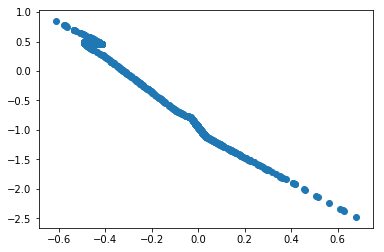

In [3]:
# samples = [gan.sample_images(i) for i in np.linspace(-2, 2, 1000)]
samples = [gan.sample_images(np.random.normal()) for i in np.linspace(-2, 2, 1000)]
samples = np.vstack(samples)

plt.figure()
plt.scatter(samples[:,0], samples[:,1]);

In [4]:
from tqdm import tqdm
import random
def sample_toy_distr():
    x = np.random.normal(0, 0.1)
    y = np.random.normal(0, 0.1)
#     centers = [(i*5,j*10) for i in range(NUMBER_OF_GAUSSIANS) for j in range(NUMBER_OF_GAUSSIANS)] 
    centers = [(0,-1), (1,0), (-0.5,0.5)]

    mu_x, mu_y = random.sample(centers,1)[0]
    return [x + mu_x, y + mu_y]

r_samples = [sample_toy_distr() for i in tqdm(np.linspace(-1, 1, 10000))]
r_samples = np.vstack(r_samples)

100%|██████████| 10000/10000 [00:00<00:00, 36064.06it/s]


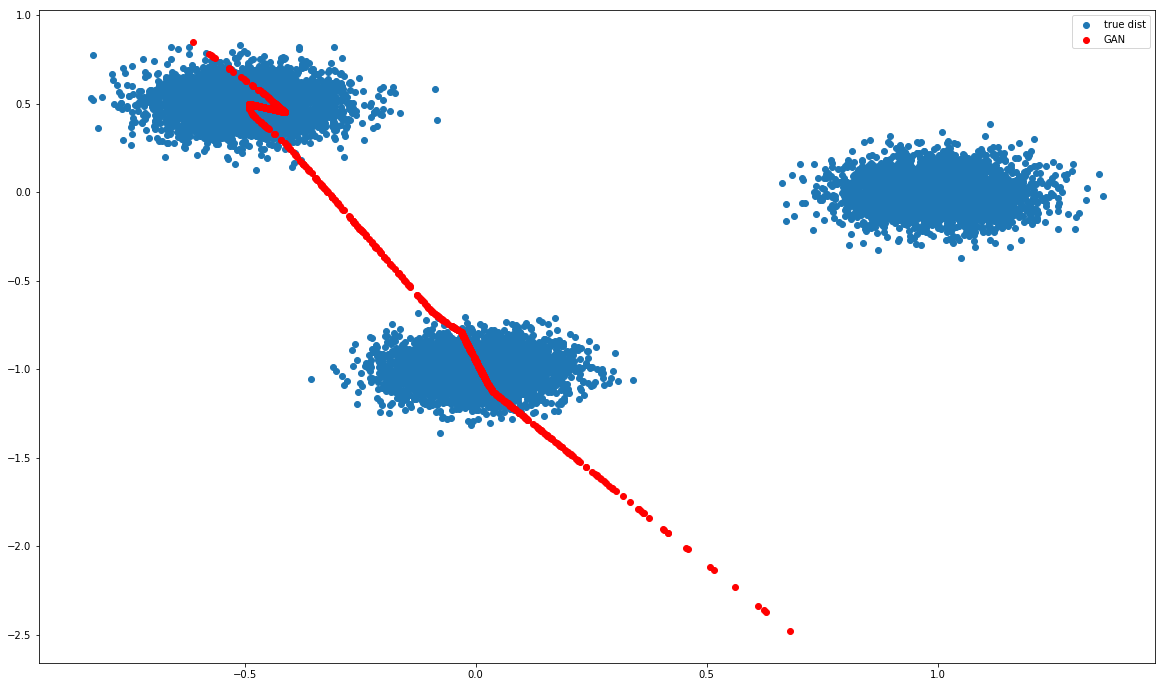

In [5]:
plt.figure(figsize=(20,12))
plt.scatter(r_samples[:,0], r_samples[:,1], label='true dist')
plt.scatter(samples[:,0], samples[:,1], c='r', label='GAN');
plt.legend();